# Predicting startup success

The goal of this project is to predict the success of a business. Let's assume that our objective is to predict the total capital a startup will raise (if any) over 2 funding rounds, its Angel and Series A fundings. We could then utilise the outcome to predict whether the company will raise a Series A specifically.

__Note__: The goal of this project is not to necessarily build the best model for predictions, as the input data is incomplete and incorrect to a great extent (for example many funding rounds were never disclosed), but to present the modelling solution we generated, the analytical process followed and the Data Science/ML techniques utilised throughout the process.

### Importing necessary modules

In [1]:
# we need at least Python 3.5 and Scikit-Learn 0.20
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=15)
mpl.rc('axes', labelpad=5.0)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Loading the data

In [2]:
import tarfile
import os

DATA_PATH = os.path.join(".", "it_is_happening_data")

def extract_data(data_path=DATA_PATH):
    if not os.path.exists("it_is_happening_data"):
        os.makedirs(data_path)
        data_tgz = tarfile.open("Data.tar.gz")
        data_tgz.extractall(data_path)
        data_tgz.close()

In [3]:
extract_data()

In [4]:
datasets = ('funding_rounds.csv', 'elements.csv', 
                     'persons.csv', 'relationships.csv')

def load_data(data_path=DATA_PATH):
    csv_dict = {}
    for csv_file in datasets:
        print(f"Creating DataFrame: {csv_file[:-4]}")
        csv_path = os.path.join(data_path, csv_file)
        df = pd.read_csv(csv_path, error_bad_lines=False, warn_bad_lines=False)
        csv_dict[csv_file[:-4]] = df
    return csv_dict

In [5]:
# turning off unnecassary warnings
pd.options.mode.chained_assignment = None

from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)

In [6]:
# loading the data
csvs = load_data()

# naming DataFrames properly
funding_rounds, elements, persons, relationships = csvs['funding_rounds'], \
                            csvs['elements'], csvs['persons'], csvs['relationships']

Creating DataFrame: funding_rounds
Creating DataFrame: elements
Creating DataFrame: persons
Creating DataFrame: relationships


### Taking a quick/first look at the datasets

__Dataset__: `funding_rounds`

In [7]:
print(funding_rounds.info(), "\n")

# checking the top counts of values of the raised_amount_usd feature
print(f"Most common raised sums\n")
print(funding_rounds['raised_amount_usd'].value_counts().head(), "\n")

# taking a look at critical features
print(f"A look at important features\n")
funding_rounds[['funding_round_type', 'funding_round_code', 'raised_amount_usd']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52920 entries, 0 to 52919
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        52920 non-null  int64 
 1   funding_round_id          52920 non-null  int64 
 2   object_id                 52920 non-null  object
 3   funded_at                 52920 non-null  object
 4   funding_round_type        52920 non-null  object
 5   funding_round_code        52920 non-null  object
 6   raised_amount_usd         52920 non-null  object
 7   raised_amount             52920 non-null  object
 8   raised_currency_code      52920 non-null  object
 9   pre_money_valuation_usd   52920 non-null  object
 10  pre_money_valuation       52920 non-null  object
 11  pre_money_currency_code   52920 non-null  object
 12  post_money_valuation_usd  52920 non-null  object
 13  post_money_valuation      52920 non-null  object
 14  post_money_currency_co

,funding_round_type,funding_round_code,raised_amount_usd
0,series-b,b,8500000
1,angel,angel,500000
2,series-a,a,12700000
3,series-b,b,27500000
4,series-b,b,10500000
...,...,...,...
52915,series-a,a,3000000
52916,venture,partial,570000
52917,venture,unattributed,2184100
52918,series-a,a,790783


<ins>__Dataset__</ins>: `elements`

In [8]:
print(elements.info())
elements.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538171 entries, 0 to 538170
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   538171 non-null  object
 1   entity_type          478831 non-null  object
 2   entity_id            475564 non-null  object
 3   parent_id            473190 non-null  object
 4   name                 471660 non-null  object
 5   normalized_name      470661 non-null  object
 6   permalink            469988 non-null  object
 7   category_code        469449 non-null  object
 8   status               469118 non-null  object
 9   founded_at           468876 non-null  object
 10  closed_at            468720 non-null  object
 11  domain               468618 non-null  object
 12  homepage_url         468540 non-null  object
 13  twitter_username     468472 non-null  object
 14  logo_url             468431 non-null  object
 15  logo_width           468397 non-nu

,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,...,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,created_by,created_at,updated_at
0,c:1,Company,1,\N,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,...,2008-05-19,3,39750000,2010-09-05,2013-09-18,5,17,initial-importer,2007-05-25 06:51:27,2013-04-13 03:29:00
1,c:10,Company,10,\N,Flektor,flektor,/company/flektor,games_video,acquired,\N,...,\N,\N,\N,\N,\N,\N,6,initial-importer,2007-05-31 21:11:51,2008-05-23 23:23:14
2,c:100,Company,100,\N,There,there,/company/there,games_video,acquired,\N,...,\N,\N,\N,2003-02-01,2011-09-23,4,12,initial-importer,2007-08-06 23:52:45,2013-11-04 02:09:48
3,c:10000,Company,10000,\N,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,2008-07-26,...,\N,\N,\N,\N,\N,\N,\N,\N,2008-08-24 16:51:57,2008-09-06 14:19:18
4,c:10001,Company,10001,\N,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,2008-07-26,...,\N,\N,\N,\N,\N,\N,\N,\N,2008-08-24 17:10:34,2008-09-06 14:19:18


We will check for __startup-related information__ in the `entity_type` column (we're assuming that the word 'start' refers to startups in most cases and want to check if that's true).

In [9]:
print(f"Number of rows containing (or not) possible startup-related information (column: 'entity_type')\n")
print(pd.Series(elements['entity_type'].value_counts().keys().str.contains('start',case=False)).value_counts(),"\n")

# viewing some relevant cases
print(f"Actual 'True' cases\n")
elements['t1'] = pd.Series(elements['entity_type'].str.contains('start',case=False))
print(elements.loc[elements['t1'] == True]['entity_type'].head())
elements.drop('t1',axis=1,inplace=True)

Number of rows containing (or not) possible startup-related information (column: 'entity_type')

False    15870
True       322
dtype: int64 

Actual 'True' cases

312      you can start populating your Virsona with yo...
2613     a web services start up . Available at www.sa...
3026     site management and traffic analysis software...
3848     2011 in one of the first projects of the proj...
4647                         a recently launched startup.
Name: entity_type, dtype: object


In [10]:
# counts of values greater than 2 for the 'description' feature (NaNs included)
elements['description'].value_counts(dropna=False).loc[lambda x: x>2]

\N                                336300
NaN                               103784
1                                    597
private equity                       356
Venture Capital Firm                 354
                                   ...  
Social TV                              3
In-Game Advertising                    3
Digital Ad Agency                      3
manufacturers and suppliers            3
Mobile advertising marketplace         3
Name: description, Length: 1366, dtype: int64

In [11]:
# some rows from location-related features
print(f"Some rows from location-related features\n")
print(elements[['country_code', 'state_code', 'city', 'region']].head(7), "\n")

# incorrect entries of geographical data
print(f"Incorrect entries of geographical data (from the 'country_code' and 'state_code' features)\n")
print(elements['country_code'].value_counts().tail(),"\n")
print(elements['state_code'].value_counts().tail())

Some rows from location-related features

  country_code state_code         city       region
0          USA         WA      Seattle      Seattle
1          USA         CA  Culver City  Los Angeles
2          USA         CA    San Mateo       SF Bay
3           \N         \N           \N      unknown
4           \N         \N           \N      unknown
5          MAR         \N       Agadir       Agadir
6          IND         \N     Vadodara     Vadodara 

Incorrect entries of geographical data (from the 'country_code' and 'state_code' features)

 and an non-intrusive media vehicle for advertisers.                                                                                                                                                                                                                                                                                                 1
 Search Appliances                                                                                       

__Note__: As we can see in the previous cell, the geographical features (among many others) are not clean. We will tackle this issue later.

<ins>__Dataset__</ins>: `persons`

In [12]:
print("Dataset size: ", len(persons))
persons.head()

Dataset size:  226706


,id,object_id,first_name,last_name,birthplace,affiliation_name
0,1,p:2,Ben,Elowitz,\N,Blue Nile
1,2,p:3,Kevin,Flaherty,\N,Wetpaint
2,3,p:4,Raju,Vegesna,\N,Zoho
3,4,p:5,Ian,Wenig,\N,Zoho
4,5,p:6,Kevin,Rose,"Redding, CA",i/o Ventures


<ins>__Dataset__</ins>: `relationships`

In [13]:
print("Dataset size: ", len(relationships), "\n")
print(f"Initial column headers:\n{relationships.columns.values}\n")

# fixing the column names
relationships.columns = [i.replace("'","") for i in relationships.columns]
relationships.head()

Dataset size:  402875 

Initial column headers:
["'id'" "'relationship_id'" "'person_object_id'"
 "'relationship_object_id'" "'start_at'" "'end_at'" "'is_past'"
 "'sequence'" "'title'" "'created_at'" "'updated_at'"]



,id,relationship_id,person_object_id,relationship_object_id,start_at,end_at,is_past,sequence,title,created_at,updated_at
0,1,1,p:2,c:1,\N,\N,0,8,Co-Founder/CEO/Board of Directors,2007-05-25 07:03:54,2013-06-03 09:58:46
1,2,2,p:3,c:1,\N,\N,1,279242,VP Marketing,2007-05-25 07:04:16,2010-05-21 16:31:34
2,3,3,p:4,c:3,\N,\N,0,4,Evangelist,2007-05-25 19:33:03,2013-06-29 13:36:58
3,4,4,p:5,c:3,2006-03-01,2009-12-01,1,4,Senior Director Strategic Alliances,2007-05-25 19:34:53,2013-06-29 10:25:34
4,6,6,p:7,c:4,2005-07-01,2010-04-05,1,1,Chief Executive Officer,2007-05-25 20:05:33,2010-04-05 18:41:41


In [14]:
# highest numbers of relationships
print(f"Most relationships (top-5)\n")
print(relationships['relationship_object_id'].value_counts().head(), "\n")

# relationships of a specific company
print("Relationships of a random company")
relationships.loc[relationships['relationship_object_id'] == 'c:233024']

Most relationships (top-5)

c:1242    1178
c:59      1044
c:29       979
c:3246     864
c:4715     660
Name: relationship_object_id, dtype: int64 

Relationships of a random company


,id,relationship_id,person_object_id,relationship_object_id,start_at,end_at,is_past,sequence,title,created_at,updated_at
8755,11367,11367,p:2,c:233024,\N,\N,1,2,Business Development,2008-05-06 00:04:18,2013-06-02 16:56:52
244344,292555,292555,p:164274,c:233024,1997-01-01,2000-01-01,1,1,Sales Manager,2013-06-28 14:43:51,2013-06-28 14:43:51
252664,303292,303292,p:12657,c:233024,1996-01-01,1997-01-01,1,4,VP Marketing and Editorial,2013-07-09 08:21:59,2013-07-09 08:21:59
279086,335844,335844,p:215039,c:233024,\N,\N,1,5,Board of Director,2013-08-03 10:45:35,2013-09-03 11:26:09
280955,338284,338284,p:23196,c:233024,\N,\N,1,9,Investment,2013-08-05 11:40:58,2013-08-05 11:40:58


### Initial Wrangling/Cleaning

We will first check for duplicate rows and remove them.

In [15]:
# function that returns the number of duplicate rows for multiple DataFrames 
def print_duplicates_num(dfs,dts):
    print(f"{'duplicates per dataset'.upper()}\n")
    for i in range(len(dfs)):
        print(f"{dts[i][:-4]}\n{dfs[i].duplicated().value_counts()}\n")

In [16]:
# all DataFrames
dataframes = (funding_rounds, elements, persons, relationships)
# getting the duplicate rows per DataFrame
print_duplicates_num(dataframes, datasets)

DUPLICATES PER DATASET

funding_rounds
False    52920
dtype: int64

elements
False    488540
True      49631
dtype: int64

persons
False    226706
dtype: int64

relationships
False    402875
dtype: int64



In [17]:
# function for removing duplicate rows (for multiple DataFrames)
def remove_duplicate_rows(dfs):
    for df in dfs:
        if df.duplicated().value_counts().get(True) != None: # we could use df.duplicated().any() but this is faster
            df.drop_duplicates(inplace=True)

In [18]:
# REMOVING DUPLICATE ROWS
remove_duplicate_rows(dataframes)

### Initial "manual" feature selection

We will now manually remove some features that are not helpful/relevant with regard to the predictions we will make and also "id" columns that will not be used for merging the separate datasets, so as to lighten our datasets.

<ins>__Features to remove__</ins>

In [19]:
# 'funding_rounds' dataset
funding_rounds_cols_out = ['id', 'funding_round_id', 'raised_amount', 'pre_money_currency_code', 
                        'pre_money_valuation', 'post_money_valuation','post_money_currency_code',
                           'is_first_round', 'is_last_round', 'source_url', 'source_description',
                           'created_by', 'created_at', 'updated_at ']

# 'elements' dataset 
elements_cols_out = ['entity_id', 'normalized_name', 'permalink', 'homepage_url', 'logo_url',
                    'short_description', 'overview', 'created_by', 'created_at', 'updated_at']

# 'persons' dataset
persons_cols_out = ['id']

# 'relationships' dataset
relationships_cols_out = ['id', 'relationship_id', 'is_past', 'sequence', 'created_at', 'updated_at']

# all lists with columns to de dropped
cols_out_lists = (funding_rounds_cols_out, elements_cols_out,
                 persons_cols_out, relationships_cols_out)

<ins>**Dropping features**</ins>

In [20]:
# defining a function for dropping all columns we want to remove at once
def drop_columns(dfs,out_lists):
    for i in range(len(dfs)):
        dfs[i].drop(out_lists[i], axis=1, inplace=True)

In [21]:
# DROPPING COLUMNS
drop_columns(dataframes, cols_out_lists)

## Creating our unified dataset

We will first __add a new feature__ containing the **_full names of affiliated persons_** to the `persons` dataset.

In [22]:
# ADDING THE FEATURE 'full_name' TO THE 'persons' dataset (concatenating without whitespaces in between to encode this text feature more efficiently later)
persons['full_name'] = persons['first_name'] + persons['last_name']

# removing columns we do not need anymore
persons.drop(['first_name', 'last_name'], axis=1, inplace=True)

# removing any existing whitespaces
persons['full_name'] = persons['full_name'].str.replace(" ","")
persons['full_name']

0             BenElowitz
1          KevinFlaherty
2            RajuVegesna
3               IanWenig
4              KevinRose
               ...      
226701          JohnPins
226702     DavidSchulhof
226703    MatthewD.Rosen
226704    GordonHutchins
226705       DeniseBasow
Name: full_name, Length: 226706, dtype: object

### Merging datasets

<ins>Schema for merging</ins>:

| Datasets pair | Respective Keys |
|:-|:-|
| elements - funding_rounds | 'id' - 'object_id' |
| relationships - persons | 'person_object_id' - 'object_id' |
| elements - relationships | 'id' - 'relationship_object_id' |

We will now merge the separate datasets and also take a look at persons involved in many fundings.

In [23]:
# MERGING THE 'funding_rounds' AND 'elements' DATASETS
temp1 = funding_rounds.merge(elements, left_on='object_id',right_on='id')

# MERGING THE 'relationships' AND 'persons' DATASETS
temp2 = persons.merge(relationships, left_on='object_id',right_on='person_object_id')

# removing duplicate rows
temp2 = temp2.drop_duplicates().reset_index().drop('index',axis=1)

# persons involved in many fundings
print("Persons involved in multiple fundings\n")
print(temp2['full_name'].value_counts().head(), "\n")

print("Merged dataset (some rows)")
temp2.head()

Persons involved in multiple fundings

DanielLeff        70
BettyKayton       69
NihalMehta        64
BandelL.Carano    63
RogerEhrenberg    61
Name: full_name, dtype: int64 

Merged dataset (some rows)


,object_id,birthplace,affiliation_name,full_name,person_object_id,relationship_object_id,start_at,end_at,title
0,p:2,\N,Blue Nile,BenElowitz,p:2,c:1,\N,\N,Co-Founder/CEO/Board of Directors
1,p:2,\N,Blue Nile,BenElowitz,p:2,c:4993,\N,\N,Co-founder & VP
2,p:2,\N,Blue Nile,BenElowitz,p:2,c:233024,\N,\N,Business Development
3,p:2,\N,Blue Nile,BenElowitz,p:2,f:1017,\N,\N,Limited Partner
4,p:2,\N,Blue Nile,BenElowitz,p:2,c:18661,\N,\N,Consultant


### Adding new features

We will now add some new features to the _relationships-persons_ merged dataset. These features are:

__<ins>Text features</ins>__

1. all the names of affiliated organizations per company
2. all affiliated persons per company
3. all persons' birthplaces per company
4. all persons' titles per company

__<ins>Numerical features</ins>__

5. the duration of every relationship (in days) for every company

These new features will be generated by aggregating data related to all the fundings a company secured.

In [24]:
# defining a function for removing 'weird' text (single characters/character sequences) from a series
allowed_chars_names = [" ", "'", '&', ',','.','-','(',')','’', '–', '/'] # suitable for names
allowed_chars_firms = [' ', "'", '&', ',', '.', '-', '(', ')', '’', '–', '/', '!','%','*','+',':',';',
                 '@','[',']','|','©','®','°','²','•','™'] # suitable for companies names
allowed_chars_places = [' ', "'", '&', ',', '.', '-', '(', ')', '’', '–',
                        '/',';','|'] # suitable for regions
allowed_chars_titles = [' ', "'", '&', ',', '.', '-', '(', ')', '/',';','|', '!', '#','$','+',
                  '@', '_', '[', ']', '®','–','—','’'] # suitable for titles

def remove_uncommon_text(ser, allowed):
    se1 = set()
    for row in ser:
        for char in str(row):
            if not char.isalpha() and char not in allowed:
                se1.add(char) # se1 provides the characters/strings to be removed
    for char in se1:
        ser = ser.apply(lambda x: str(x).replace(char, ''))
    return ser

In [25]:
# defining a function for aggregating data from a company's various fundings
def grouped_text_column(df1, col, groupby_col, has_commas=False, remove=False, allowed_chars=None):
    new_feat = df1.copy()
    new_feat[col] = new_feat[col].dropna()
    new_feat[col] = new_feat[col].astype('object')
    if has_commas:
        new_feat = new_feat.groupby([groupby_col])[col].apply(lambda x: "".join(x.to_string(index=False))).str.replace('(\\n)', '-').reset_index()
        new_feat[col] = new_feat[col].apply(lambda x: x.replace("\\N-", "")).apply(lambda x: x.replace(" ", "")).apply(lambda x: x.replace("\\N", "")).apply(lambda x: x[:-1] if len(x)>0 and x[-1] == '-' else x)
    else:
        new_feat = new_feat.groupby([groupby_col])[col].apply(lambda x: "".join(x.to_string(index=False))).str.replace('(\\n)', ',').reset_index()
        new_feat[col] = new_feat[col].apply(lambda x: x.replace("NaN,", "")).apply(lambda x: "".join(x.split()))
    if remove:
        new_feat[col] = remove_uncommon_text(new_feat[col], allowed_chars)
    return new_feat

<ins>**Creating the features**</ins> (the final names of the features will be given later, when adding the features)

In [26]:
# 'persons_names' feature
feat_1 = grouped_text_column(temp2, 'full_name', 'relationship_object_id', remove=True, 
                             allowed_chars=allowed_chars_names)
print(feat_1['full_name'].head(), "\n")

# 'all_affiliations' feature
feat_2 = grouped_text_column(temp2, 'affiliation_name', 'relationship_object_id', remove=True, 
                             allowed_chars=allowed_chars_firms)
print(feat_2.head(),"\n")

# 'persons_birthplaces' feature
feat_3 = grouped_text_column(temp2, 'birthplace', 'relationship_object_id', remove=True, 
                             has_commas=True, allowed_chars=allowed_chars_places)
print(feat_3.head(), "\n")

# 'persons_titles' feature
feat_4 = grouped_text_column(temp2, 'title', 'relationship_object_id', remove=True, 
                             allowed_chars=allowed_chars_titles)
feat_4.head()

0    BenElowitz,KevinFlaherty,GusTai,TheresiaRanzet...
1    JasonRubin,AndyGavin,JasonKay,ScottShumaker,Ry...
2    JimWhite,MichaelWilson,JeffreyVentrella,WillHa...
3                         YounesQassimi,AhmedChergaoui
4                                           TaylorBarr
Name: full_name, dtype: object 

  relationship_object_id                                   affiliation_name
0                    c:1  BlueNile,Wetpaint,BillShrink,ForeScout,Unaffil...
1                   c:10  MonkeyGods,Flektor,Flektor,Unaffiliated,Magnif...
2                  c:100  Farecast,There,There,There,There,LimeLife,Unaf...
3                c:10002                         SynergieMedia,Unaffiliated
4               c:100042                                           iContact 

  relationship_object_id   birthplace
0                    c:1             
1                   c:10  USA-Hungary
2                  c:100             
3                c:10002             
4               c:100042   Atlanta,GA 



,relationship_object_id,title
0,c:1,"Co-Founder/CEO/BoardofDirectors,VPMarketing,Bo..."
1,c:10,"Co-founderandCEO,Co-founderandCTO,COO,Co-Found..."
2,c:100,"BoardofDirectors,CEO,Co-Founder,Co-Founder,Pre..."
3,c:10002,"Founder,CreativeDirector"
4,c:100042,GeneralManager


<ins>**Creating the `relationships_days` feature**</ins>

In [27]:
# defining a function for aggregating numerical data from various rounds for every company
def grouped_num_column(df1, col, groupby_col):
    new_feat = df1.copy()
    new_feat = new_feat.groupby([groupby_col])[col].sum().to_frame()
    return new_feat

At this point we will add a column with the __duration (in days) of every relationship__ to the _relationships-persons_ (temp3) dataset.

In [28]:
# start dates of relationships
rel_start = pd.to_datetime(temp2['start_at'], errors='coerce')

# end dates of relationships
rel_end = pd.to_datetime(temp2['end_at'], errors='coerce')

# relationships durations in days
temp2['relationship_days'] = (rel_end - rel_start).dt.days

# ADDING THE FEATURE
feat_5 = grouped_num_column(temp2, 'relationship_days', 'relationship_object_id')

# most common values of the feature
print(f"Most common values for the new feature:\n\n{feat_5['relationship_days'].value_counts(dropna=False).head()}\n")

# checking for inappropriate (negative) values
print("Negative duration cases:", len(feat_5.loc[feat_5['relationship_days'] <0]))

# replacing negative values with 0
print("Replacing negative values with 0")
feat_5['relationship_days'] = feat_5['relationship_days'].apply(lambda x: 0 if x <0 else x)

Most common values for the new feature:

0.0       90254
365.0      4305
730.0      2754
731.0      2598
1096.0     2552
Name: relationship_days, dtype: int64

Negative duration cases: 210
Replacing negative values with 0


Let's now **add the features** to the _relationships-persons_ dataset (and provide the final column names).

In [29]:
features_to_add = [feat_1, feat_2, feat_3, feat_4, feat_5]
initial_names = ['full_name', 'affiliation_name', 'birthplace', 'title', 'relationship_days']
final_names = ['persons_names', 'all_affiliations', 'persons_birthplaces', 
               'persons_titles', 'relationships_days']

# function for adding the features
def add_features(features, init_names, fin_names):
    startdf = temp2
    for i in range(len(fin_names)):
        tempdf = startdf.merge(features[i], left_on='relationship_object_id', 
                               right_on='relationship_object_id')
        tempdf = tempdf.drop_duplicates(subset='relationship_object_id').reset_index().drop(['index',init_names[i]+'_x'],axis=1).rename(columns={init_names[i]+'_y':fin_names[i]})
        startdf = tempdf
    return tempdf

In [30]:
# adding the features
features_df = add_features(features_to_add, initial_names, final_names)

features_df.head()

,object_id,person_object_id,relationship_object_id,start_at,end_at,persons_names,all_affiliations,persons_birthplaces,persons_titles,relationships_days
0,p:2,p:2,c:1,\N,\N,"BenElowitz,KevinFlaherty,GusTai,TheresiaRanzet...","BlueNile,Wetpaint,BillShrink,ForeScout,Unaffil...",,"Co-Founder/CEO/BoardofDirectors,VPMarketing,Bo...",2923.0
1,p:2,p:2,c:4993,\N,\N,"BenElowitz,AlexBerg,KevinFrisch,MarkVadon,Bria...","BlueNile,Unaffiliated,Unaffiliated,Unaffiliate...",,"Co-founder&VP,DirectorofSiteDevelopment,Senior...",4383.0
2,p:2,p:2,c:233024,\N,\N,"BenElowitz,TomBlaisdell,WilliamStewart,ShaneOr...","BlueNile,Unaffiliated,Unaffiliated,Unaffiliate...",,"BusinessDevelopment,VPMarketingandEditorial,In...",1461.0
3,p:2,p:2,f:1017,\N,\N,"BenElowitz,KevinFlaherty,KevinFlaherty,StuartD...","BlueNile,Wetpaint,Wetpaint,Unaffiliated,Occipi...","Indianapolis,INUSA-London,England-SanPadro,CA-...","LimitedPartner,LimitedPartner,mentor,LimitedPa...",0.0
4,p:2,p:2,c:18661,\N,\N,"BenElowitz,MegWhitman,GilPenchina,EricBaker,To...","BlueNile,Zipcar,Wikia,Viagogo,Jam,CheapToday,C...","london,england-Chicago,IL-Phoenix,AZ-Massachus...","Consultant,ExecutiveLevelPositions,Associate,a...",185408.0


The time has come to **add the _relationships-persons dataset with the new features_** (features_df) to the _funding_rounds-elements_ dataset (temp1) and then produce some insights.

In [31]:
temp3 = temp1.merge(features_df, how='left', left_on='id',right_on='relationship_object_id')

# checking how many unique companies have been valued at $2M after raising funds
print("Post-funding valuations of $2M:")
print(temp3.loc[temp3['post_money_valuation_usd'] == '2000000']['id'].nunique(), "\n")

# fundings per month
print("Fundings per month")
print(pd.to_datetime(temp3['funded_at'],errors='coerce').dt.month.value_counts(), "\n")

# checking out some data for acquired companies
print("Some data about acquired companies", "\n")
print(temp3[['funding_round_type','raised_amount_usd','id','status','founded_at',
    'funding_rounds','funding_total_usd']].loc[temp3['status'] == 'acquired'].head())

Post-funding valuations of $2M:
46 

Fundings per month
1.0     6727
6.0     4440
10.0    4376
9.0     4308
5.0     4200
8.0     4156
4.0     4142
7.0     4120
3.0     4091
11.0    3983
12.0    3682
2.0     3415
Name: funded_at, dtype: int64 

Some data about acquired companies 

   funding_round_type raised_amount_usd      id    status  founded_at  \
0            series-b           8500000     c:4  acquired  2004-10-11   
1            series-a           2800000     c:4  acquired  2004-10-11   
2           series-c+          28700000     c:4  acquired  2004-10-11   
3           series-c+           5000000     c:4  acquired  2004-10-11   
15           series-b          10500000  c:7299  acquired  2003-06-01   

   funding_rounds funding_total_usd  
0             NaN               NaN  
1             NaN               NaN  
2             NaN               NaN  
3             NaN               NaN  
15              7          33672656  


We will now __drop columns__ we do not need anymore.

In [32]:
# dropping columns
temp3 = temp3.drop(['object_id_x', 'parent_id', 'object_id_y', 'person_object_id', 
                    'relationship_object_id', 'start_at', 'end_at'], axis=1)
# the resulting DataFrame
temp3

,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_currency_code,pre_money_valuation_usd,post_money_valuation_usd,participants,id,entity_type,...,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,persons_names,all_affiliations,persons_birthplaces,persons_titles,relationships_days
0,2006-12-01,series-b,b,8500000,USD,\N,\N,2,c:4,Company,...,NaN,NaN,NaN,NaN,NaN,"KevinRose,JayAdelson,OwenByrne,RonGorodetzky,D...","i/oVentures,Digg,Digg,Digg,TinySpeck,LinkedIn,...","Redding,CA-Detroit,MI-NewRochelle,NewYork-Illi...","Founder&CEO,ChiefExecutiveOfficer,SeniorSoftwa...",26522.0
1,2005-10-01,series-a,a,2800000,USD,\N,\N,8,c:4,Company,...,NaN,NaN,NaN,NaN,NaN,"KevinRose,JayAdelson,OwenByrne,RonGorodetzky,D...","i/oVentures,Digg,Digg,Digg,TinySpeck,LinkedIn,...","Redding,CA-Detroit,MI-NewRochelle,NewYork-Illi...","Founder&CEO,ChiefExecutiveOfficer,SeniorSoftwa...",26522.0
2,2008-09-24,series-c+,c,28700000,USD,\N,\N,4,c:4,Company,...,NaN,NaN,NaN,NaN,NaN,"KevinRose,JayAdelson,OwenByrne,RonGorodetzky,D...","i/oVentures,Digg,Digg,Digg,TinySpeck,LinkedIn,...","Redding,CA-Detroit,MI-NewRochelle,NewYork-Illi...","Founder&CEO,ChiefExecutiveOfficer,SeniorSoftwa...",26522.0
3,2011-07-12,series-c+,d,5000000,USD,\N,\N,0,c:4,Company,...,NaN,NaN,NaN,NaN,NaN,"KevinRose,JayAdelson,OwenByrne,RonGorodetzky,D...","i/oVentures,Digg,Digg,Digg,TinySpeck,LinkedIn,...","Redding,CA-Detroit,MI-NewRochelle,NewYork-Illi...","Founder&CEO,ChiefExecutiveOfficer,SeniorSoftwa...",26522.0
4,2004-09-01,angel,angel,500000,USD,\N,\N,2,c:5,Company,...,NaN,NaN,NaN,NaN,NaN,"MarkZuckerberg,DustinMoskovitz,OwenVanNatta,Ma...","Facebook,Facebook,Asana,LinkedIn,GeneralCataly...","Gainesville,FL-Hickery,NorthCarolina-CedarFall...","FounderandCEO,BoardOfDirectors,Co-Founder,Chie...",77960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51870,2010-04-07,venture,unattributed,120000,USD,\N,\N,0,c:256895,Company,...,120000,\N,\N,\N,3,"MaurizioVecchione,HenkyWibowo,MarkStolper","Thwapr,Unaffiliated,Unaffiliated","Zurich,Switzerland","CEO,VicePresidentofSoftware,Chairman",0.0
51871,2010-02-06,other,debt_round,1800180,USD,\N,\N,0,c:37738,Company,...,1800180,\N,\N,\N,8,"MichaelPowell,DrewSenyei,LouisBock,EckardWeber...","Curverider,Unaffiliated,Unaffiliated,Unaffilia...",,"Investor,BoardofDirectors,Director,BoardChairm...",0.0
51872,2013-12-12,series-a,a,3000000,USD,\N,\N,1,c:211890,Company,...,3000000,2007-10-19,2013-12-12,3,4,"JacobBlackstock,DavidKennedy,DorianBaldwin,Sha...","Unaffiliated,Unaffiliated,Unaffiliated,Unaffil...",,"CEO,CTO,InteractiveDeveloper,VP,BusinessDevelo...",0.0
51873,2013-12-12,series-a,a,790783,USD,\N,\N,0,c:285864,Company,...,790783,\N,\N,\N,1,RomanGaus,Unaffiliated,,CEO,0.0


### Altering data types of columns

In [33]:
temp3.dtypes

funded_at                    object
funding_round_type           object
funding_round_code           object
raised_amount_usd            object
raised_currency_code         object
pre_money_valuation_usd      object
post_money_valuation_usd     object
participants                  int64
id                           object
entity_type                  object
name                         object
category_code                object
status                       object
founded_at                   object
closed_at                    object
domain                       object
twitter_username             object
logo_width                   object
logo_height                  object
description                  object
tag_list                     object
country_code                 object
state_code                   object
city                         object
region                       object
first_investment_at          object
last_investment_at           object
investment_rounds           

In [34]:
# columns to be converted to Datetime columns
datetime_cols = ['funded_at', 'founded_at', 'closed_at', 'first_investment_at',
                 'last_investment_at', 'first_funding_at', 'last_funding_at',
                'first_milestone_at', 'last_milestone_at']

# columns to be converted to numerical ones
num_cols = ['raised_amount_usd', 'pre_money_valuation_usd', 'post_money_valuation_usd',
             'funding_total_usd', 'logo_width', 'logo_height', 'investment_rounds', 
            'invested_companies', 'funding_rounds', 'milestones', 'relationships']

# defining a function for converting columns to the 'datetime' / 'numeric' format
def convert_columns(df, cols, dtype):
    if dtype == 'dt':
        for col in cols:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    elif dtype == 'num':
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')

<ins>__Converting columns__</ins>

__Note__: We will convert all numerical columns to the `float` data type, so as to deal with `NaN` values more easily later.

In [35]:
# datetime
convert_columns(temp3, datetime_cols, 'dt')

# numeric
convert_columns(temp3, num_cols, 'num')

temp3.dtypes

funded_at                   datetime64[ns]
funding_round_type                  object
funding_round_code                  object
raised_amount_usd                  float64
raised_currency_code                object
pre_money_valuation_usd            float64
post_money_valuation_usd           float64
participants                         int64
id                                  object
entity_type                         object
name                                object
category_code                       object
status                              object
founded_at                  datetime64[ns]
closed_at                   datetime64[ns]
domain                              object
twitter_username                    object
logo_width                         float64
logo_height                        float64
description                         object
tag_list                            object
country_code                        object
state_code                          object
city       

## Exploring data

<ins>**Analysing data relevant to _Series A fundings_**</ins>

In [36]:
seriesa = temp3.loc[temp3['funding_round_type'] == 'series-a']
# number of Series A fundings
print('Number of Series A Fundings:', len(seriesa))

# number of unique companies that raised a Series A
print('Unique companies:',seriesa['id'].nunique(), "\n")

# viewing some rows of all the funding-related features (name-wise)
print("Some rows from funding-related features (name-wise)")
seriesa.filter(like='fund').head()

Number of Series A Fundings: 9665
Unique companies: 8711 

Some rows from funding-related features (name-wise)


,funded_at,funding_round_type,funding_round_code,first_funding_at,last_funding_at,funding_rounds,funding_total_usd
1,2005-10-01,series-a,a,NaT,NaT,NaN,NaN
5,2005-05-01,series-a,a,NaT,NaT,NaN,NaN
16,2005-03-01,series-a,a,2005-03-01,2013-05-14,7.0,33672656.0
17,2006-11-10,series-a,a,2005-03-01,2013-05-14,7.0,33672656.0
22,2007-01-01,series-a,a,2007-01-01,2009-01-19,3.0,16500000.0


<ins>**Exploring _fundings-related_ data**</ins>

In [37]:
# top counts of fundings values (including NaNs)
print(f"Most common funding sums\n")
print(f"{temp3['funding_total_usd'].value_counts().head()}\n")

# funding round types and respective sums raised by a specific company
print("Fundings and respective capital raised by a random company", "\n")
print(temp3.loc[temp3['id'] == 'c:4'][['funding_round_type','raised_amount_usd']], "\n")

# funding-related features (name-wise) for a specific company
print("Funding-related features for a random company")
temp3.loc[temp3['id'] == 'c:7299'].filter(like='fund')

Most common funding sums

1000000.0     715
500000.0      529
100000.0      492
2000000.0     486
10000000.0    443
Name: funding_total_usd, dtype: int64

Fundings and respective capital raised by a random company 

  funding_round_type  raised_amount_usd
0           series-b          8500000.0
1           series-a          2800000.0
2          series-c+         28700000.0
3          series-c+          5000000.0 

Funding-related features for a random company


,funded_at,funding_round_type,funding_round_code,first_funding_at,last_funding_at,funding_rounds,funding_total_usd
15,2006-05-01,series-b,b,2005-03-01,2013-05-14,7.0,33672656.0
16,2005-03-01,series-a,a,2005-03-01,2013-05-14,7.0,33672656.0
17,2006-11-10,series-a,a,2005-03-01,2013-05-14,7.0,33672656.0
18,2008-02-17,series-b,b,2005-03-01,2013-05-14,7.0,33672656.0
19,2008-05-25,series-b,b,2005-03-01,2013-05-14,7.0,33672656.0
20,2009-02-16,venture,unattributed,2005-03-01,2013-05-14,7.0,33672656.0
21,2013-05-14,venture,partial,2005-03-01,2013-05-14,7.0,33672656.0


<ins>**Exploring the `funding_rounds` and `investment_rounds` features**</ins>

In [38]:
# direct comparison
print("Number of cases where a company had equal numbers of funding and investment rounds", "\n")
print((temp3['funding_rounds'] == temp3['investment_rounds']).value_counts(), "\n")

# top 3 counts of the number of funding rounds
print(f"Total funding rounds (top 3)\n")
print(temp3['funding_rounds'].value_counts().head(3), "\n")

# top counts of the number of investment rounds
print(f"Total investment rounds (top 3)\n")
print(temp3['investment_rounds'].value_counts().head(3), "\n")

# companies with most investment rounds
print("Companies with most investment rounds (top 5)")
temp3[['investment_rounds','name']].dropna().drop_duplicates().sort_values(by='investment_rounds',ascending=False).head()

Number of cases where a company had equal numbers of funding and investment rounds 

False    51760
True       115
dtype: int64 

Total funding rounds (top 3)

1.0    19568
2.0    11578
3.0     7524
Name: funding_rounds, dtype: int64 

Total investment rounds (top 3)

1.0    287
2.0     53
3.0     33
Name: investment_rounds, dtype: int64 

Companies with most investment rounds (top 5)


,investment_rounds,name
25532,297.0,Techstars
3311,89.0,Cisco
27378,58.0,Rock Health
35895,49.0,FundersClub
25773,40.0,Seedcamp


### Checking for columns with a single value

__Note__: Columns with a single value (__zero-variance predictors__) would probably not be useful for modelling and we can remove them.

In [39]:
temp3.nunique()

funded_at                    3385
funding_round_type              9
funding_round_code             20
raised_amount_usd           10406
raised_currency_code            9
pre_money_valuation_usd        21
post_money_valuation_usd      457
participants                   32
id                          31268
entity_type                     1
name                        31268
category_code                  43
status                          4
founded_at                   2391
closed_at                     792
domain                      29582
twitter_username            18646
logo_width                   2125
logo_height                  1324
description                 17555
tag_list                    13179
country_code                  537
state_code                    340
city                         4585
region                       2557
first_investment_at           211
last_investment_at            212
investment_rounds              22
invested_companies             20
first_funding_

Based on the aforementioned the `entity_type` column will be removed.

In [40]:
# viewing the feature's unique value
print(f"Unique value to be removed:\n{temp3['entity_type'].value_counts()}")

# removing the feature
temp3 = temp3.drop('entity_type',axis=1)

Unique value to be removed:
Company    51875
Name: entity_type, dtype: int64


__Note__: We now have a much cleaner dataset than in the beginning (more cleaning/preprocessing to follow) and will share our thoughts regarding the approach we will follow to complete the project.

## Modelling approach / Mathematical solution

We will model the project as a __regression ML project__. More specifically we will have a _supervised batch multiple univariate regression project_. Treating this task as a regression one will allow us to assess whether a startup will raise a Series A funding and also predict the relevant sum (we will predict the company's total funding from the angel and Series A rounds and from that estimate its Series A sum).

To that end, we need to define a __lower threshold/bound for a Series A raised amount__. One way to do that, especially considering the structure and characteristics of the available data, is to calculate the **_upper bound of a typical angel funding_**, and assuming that this type of funding is the first one ever chronologically, we will then be able to determine if a startup will raise a Series A by predicting the total funding amount the company will secure. In case that amount is higher than the deciding value we will select as an *upper angel round threshold*, we will assume that the company will raise (at least) a Series A funding.

Our __target variable__ (our labels) will be the __total funding amount__ (feature `funding_total_usd` and as we mentioned earlier the total funding is the funding from the first 2 funding rounds in our case) and in order to calculate the necessary upper threshold we will utilise an **_optimal percentile of the aggregated angel fundings_** (so we need to calculate the total angel funding sum per company) using the categorisation of funding rounds according to the `funding_round_type`.

In order to be able to estimate the **"percentage" (sum) of a company's total funding that corresponds to its Series A**, we will carry out a relevant quick analysis (it will be presented in a bit under the title *__Estimating a total funding's Series A percentage__*; <ins>due to the fact that we are missing a lot of data, as many funding rounds have not been disclosed, the result might not necessarily be realistic</ins>).

__Notes__: 

1. We could also calculate a lower threshold with regard to Series A investments and confirm that this threshold is a value higher than the upper angel A funding, but there isn't always a clear segmentation of raised Angel and Series A sums, meaning there is some overlap between high values of angel fundings and low values of Series A (or perhaps even later stage rounds) fundings; a relevant Series A analysis under the title *__Series A round (aggregated sums) data analysis__* will be presented a bit further down. For that reason we will stick to defining an upper _angel funding_ bound using the `funding_round_type` column.


2. We carried out a quick analysis (that follows right away) to assess whether we could utilise the `funding_round_code` column to set a lower Series A threshold, but that column includes many unattributed/unassigned values and it looks a bit messy (on many occasions the categorisations of the two columns do not agree), so for categorising the various funding rounds we used solely the `funding_round_type` column.

<ins>**Analysing/Exploring data relevant to _funding round categorisations_**</ins>

In [41]:
# values & counts of the 2 different funding round categorisations
print(f"'funding_round_type' categorisation counts of values\n")
print(funding_rounds['funding_round_type'].value_counts(),"\n")

print(f"'funding_round_code' categorisation counts of values\n")
print(funding_rounds['funding_round_code'].value_counts(), "\n")

# 'funding_round_code' categories and counts for the 'other', Venture and Series A fundings from the 
# 'funding_round_type' column
print(f"TYPE CATEGORISATION: 'Other' fundings")
print(temp3.loc[temp3['funding_round_type'] == 'other']['funding_round_code'].value_counts(), "\n")
print(f"TYPE CATEGORISATION: 'Venture' fundings")
print(temp3.loc[temp3['funding_round_type'] == 'venture']['funding_round_code'].value_counts(), "\n")
print(f"TYPE CATEGORISATION: 'Series A' fundings")
print(temp3.loc[temp3['funding_round_type'] == 'series-a']['funding_round_code'].value_counts(), "\n")

# 'funding_round_type' categories and counts for the Seed and Angel fundings from the 
# 'funding_round_code' column
print(f"CODE CATEGORISATION: 'Seed' fundings")
print(temp3.loc[temp3['funding_round_code'] == 'seed']['funding_round_type'].value_counts(), "\n")
print(f"CODE CATEGORISATION: 'Angel' fundings")
print(temp3.loc[temp3['funding_round_code'] == 'angel']['funding_round_type'].value_counts())

'funding_round_type' categorisation counts of values

venture           15340
angel             13161
series-a           9872
series-b           4891
series-c+          4215
other              4200
private-equity     1043
crowdfunding        111
post-ipo             87
Name: funding_round_type, dtype: int64 

'funding_round_code' categorisation counts of values

unattributed        12225
seed                11607
a                    7998
b                    4891
debt_round           3408
angel                3238
partial              3115
c                    2498
d                    1129
private_equity       1043
grant                 776
e                     430
convertible           187
f                     145
crowd                 111
post_ipo_equity        80
secondary_market       16
g                      13
post_ipo_debt           7
crowd_equity            3
Name: funding_round_code, dtype: int64 

TYPE CATEGORISATION: 'Other' fundings
debt_round          3351
grant      

### Defining a lower bound for an Angel round funding

We will first calculate the __total funding per round for every company__.

In [42]:
grouped_rounds = temp3.groupby(['id', 'funding_round_type'])['raised_amount_usd'].sum().to_frame()
grouped_rounds['funding_round_type'] = grouped_rounds.index.get_level_values(1)
grouped_rounds = grouped_rounds.droplevel(1)
grouped_rounds = grouped_rounds.pivot(columns='funding_round_type')
print("Column headers", "\n", grouped_rounds.columns.values)
grouped_rounds.head()

Column headers 
 [('raised_amount_usd', 'angel') ('raised_amount_usd', 'crowdfunding')
 ('raised_amount_usd', 'other') ('raised_amount_usd', 'post-ipo')
 ('raised_amount_usd', 'private-equity') ('raised_amount_usd', 'series-a')
 ('raised_amount_usd', 'series-b') ('raised_amount_usd', 'series-c+')
 ('raised_amount_usd', 'venture')]


raised_amount_usd                                  \
funding_round_type             angel crowdfunding     other post-ipo   
id                                                                     
c:1                              NaN          NaN       NaN      NaN   
c:1001                           NaN          NaN       NaN      NaN   
c:10014                          0.0          NaN       NaN      NaN   
c:10015                          NaN          NaN       NaN      NaN   
c:100155                         NaN          NaN  375293.0      NaN   

                                                                                
funding_round_type private-equity   series-a   series-b   series-c+    venture  
id                                                                              
c:1                           NaN  5250000.0  9500000.0  25000000.0        NaN  
c:1001                        NaN  5000000.0        NaN         NaN        NaN  
c:10014                       NaN        NaN        NaN         NaN        NaN  
c:10015                       NaN  2000000.0  9000000.0  55000000.0  2069200.0  
c:100155                      NaN        NaN  9750000.0         NaN        NaN

In [43]:
# renaming columns
grouped_rounds.columns = [i[1]+'_usd' for i in grouped_rounds.columns.values]

print("Descriptive statistics for Series A fundings","\n")
print(grouped_rounds['series-a_usd'].describe(), "\n")

# funding summary for a random company
print(f"Fundings of a random company\n\n{grouped_rounds.loc['c:4']}\n")

# most common (aggregated) Series A funding values
print("Most common Series A funding values")
grouped_rounds['series-a_usd'].value_counts().head()

Descriptive statistics for Series A fundings 

count    8.711000e+03
mean     6.560041e+06
std      1.703557e+07
min      0.000000e+00
25%      1.600000e+06
50%      3.200000e+06
75%      6.500000e+06
max      6.817591e+08
Name: series-a_usd, dtype: float64 

Fundings of a random company

angel_usd                    NaN
crowdfunding_usd             NaN
other_usd                    NaN
post-ipo_usd                 NaN
private-equity_usd           NaN
series-a_usd           2800000.0
series-b_usd           8500000.0
series-c+_usd         33700000.0
venture_usd                  NaN
Name: c:4, dtype: float64

Most common Series A funding values


0.0          722
2000000.0    463
5000000.0    389
3000000.0    383
1500000.0    350
Name: series-a_usd, dtype: int64

In [44]:
# statistics for angel fundings
angel_rounds = grouped_rounds['angel_usd'].dropna()
angel_rounds.describe()

count    1.070200e+04
mean     3.679603e+05
std      4.604704e+05
min      0.000000e+00
25%      1.000000e+04
50%      1.547620e+05
75%      6.000000e+05
max      5.088970e+06
Name: angel_usd, dtype: float64

<ins>**Calculating the __99th percentile__ of _aggregated angel fundings_**</ins>

In [45]:
print('Angel rounds 99th percentile: ',f"{np.percentile(angel_rounds,99):,}")
print('Maximun Angel funding: ', f"{angel_rounds.max():,}")

Angel rounds 99th percentile:  1,750,000.0
Maximun Angel funding:  5,088,970.0


<ins>`Crowdfunding` data analysis</ins>

In [46]:
# statistics for crowdfunding sums
print(grouped_rounds['crowdfunding_usd'].describe())
print(f"\nMaximum crowdfunding sum: {grouped_rounds['crowdfunding_usd'].max():,}")

count    1.070000e+02
mean     1.641647e+06
std      3.962827e+06
min      0.000000e+00
25%      1.000000e+05
50%      2.575930e+05
75%      1.425000e+06
max      2.700000e+07
Name: crowdfunding_usd, dtype: float64

Maximum crowdfunding sum: 27,000,000.0


<ins>__Comments__</ins>

As we can see, 99% of all the **_aggregated angel round sums raised_** fall below the sum of \\$1,750,000  \(we are using the 99th percentile so as to deal with outliers; e.g. the maximum angel funding is a sum greater than $5M and we would not like to take that into account\). And since we assume that an angel funding is always the first funding round chronologically for a startup, if we predict that a startup will raise a total funding sum higher than this value, that means that the startup will raise a _Series A funding_. What we need to do is define how much of a company's total funding constitutes its Series A (for companies that did raise a Series A). The related analysis follows in a bit (under the title **Estimating a total funding's _Series A percentage_**).

__Note__: We do not account for the few crowdfunding rounds as it is not always certain if they take place before or after an angel round. Moreover, some crowdfunding sums are pretty high (way bigger than the angel fundings), so if we were to include them in the threshold calculation (by adding the crowdfunding fundings to the angel fundings and calculating the 99th percentile for the total sums of the 2 rounds) we would end up with *outliers that would distort our approach statistically*. We are thus <ins>excluding</ins> the crowdfunding amounts from the _Series A threshold_ calculation.

**<ins>`Series A round` (aggregated sums) data analysis</ins>**

In [47]:
seriesA_rounds = grouped_rounds['series-a_usd'].dropna()
print('Series A fundings 15th percentile', f"{np.percentile(seriesA_rounds,15):,}")

Series A fundings 15th percentile 1,000,000.0


__Note__: We can see here that the _**15th percentile of the aggregated Series A fundings**_ is a value lower than the 99th percentile (\\$1,750,000) of the respective _angel fundings_. This is not expected and, as discussed earlier, this has to do with the fact that the categorisation of funding rounds is not definite (since some seed/angel fundings are included in the Series A pool - that can be proven by the preceding funding categorisation analysis) and with the fact that many funding sums have not been disclosed.

Any further relevant analysis would be out of scope for this project though, as what is important is to present the analytical process followed to deal with the project and build a model for predictions. So, to that end, and since we cannot be sure about a Series A threshold that is fully representative, after we finalise our ML model we will utilise both the \\$1,75M value that we calculated using the Angel fundings feature and a lower value (e.g. \\$1M) that was calculated using the Series A fundings feature as Series A thresholds in order to predict how many startups will raise a Series A.

**<ins>Analysing the `funding_total_usd` feature (our labels)</ins>**

In [48]:
# filtering for rows where there is no 'total funding' value
funding_tot_na = temp3.loc[temp3['funding_total_usd'].isnull()]

# looking at important features
funding_tot_na[['name','id','raised_amount_usd','funding_total_usd']]

,name,id,raised_amount_usd,funding_total_usd
0,Digg,c:4,8500000.0,NaN
1,Digg,c:4,2800000.0,NaN
2,Digg,c:4,28700000.0,NaN
3,Digg,c:4,5000000.0,NaN
4,Facebook,c:5,500000.0,NaN
...,...,...,...,...
51842,Artoo,c:51014,NaN,NaN
51843,Ecozen Solutions,c:286063,NaN,NaN
51844,OneBreath,c:286065,NaN,NaN
51857,ROCKETHOME,c:60389,NaN,NaN


__Note__: We would normally at this point drop rows for which there is no **_total funding_** value (as we would assume that in this case a company did not raise any capital or that none of its fundings were disclosed), but as we can actually see <ins>there are many occasions where a company raised funds but (for some reason) the `funding_total_usd` value is `NaN`</ins>. 

Given the aforementioned we will add the available Angel and Series A funding amounts for every company (utilising the `grouped_rounds` DataFrame) and make the **assumption** that this is the total funding that the company secured (since we are interested in predicting whether a startup will raise a Series A). So we first need to create a DataFrame with just the Angel and Series A fundings features, as we assume that these 2 round types are the first ones to be raised chronologically (we'll ignore the few crowdfunding cases as we already mentioned and also according to the categorisation criterion we selected any seed fundings are included in the 'angel' category).

In [49]:
# selecting only the Angel and Series A fundings
grouped_rounds = grouped_rounds[['angel_usd','series-a_usd']]

# total funding for the 1st company in the 'grouped_rounds' DataFrame
print(f"Total funding for the company with id '{grouped_rounds.index[0]}': {sum(grouped_rounds.fillna(0).iloc[0,:])}")

# CALCULATING THE TOTAL USD FUNDING USING THE 'grouped_rounds' DataFrame
grouped_rounds['funding_total_usd'] = grouped_rounds.sum(axis=1)

# setting NaNs to 0
grouped_rounds = grouped_rounds.fillna(0)

grouped_rounds

Total funding for the company with id 'c:1': 5250000.0


,angel_usd,series-a_usd,funding_total_usd
id,,,
c:1,0.0,5250000.0,5250000.0
c:1001,0.0,5000000.0,5000000.0
c:10014,0.0,0.0,0.0
c:10015,0.0,2000000.0,2000000.0
c:100155,0.0,0.0,0.0
...,...,...,...
c:99853,500000.0,0.0,500000.0
c:9989,1100000.0,0.0,1100000.0
c:9994,500000.0,0.0,500000.0


__Note__: We would exclude the companies that haven't raised any capital in both rounds (angel and Series A), as normally this would mean that a startup didn't even raise an angel funding, but this is not necessarily valid due to the fact that a company might have raised a Series B (or a later stage funding) without disclosing its previous fundings, meaning its Angel and Series A fundings. For this reason **we will exclude all the cases where there was no angel funding**, even the ones where we had no Series A funding as well, meaning we'll assume that if a startup didn't raise an angel funding it didn't raise any subsequent funding (this would be expected in reality).

In [50]:
# excluding all the cases where there was no angel funding value (either because it wasn't disclosed or one was never raised)
grouped_rounds = grouped_rounds.loc[grouped_rounds['angel_usd'] != 0]
grouped_rounds.head()

,angel_usd,series-a_usd,funding_total_usd
id,,,
c:100189,250000.0,0.0,250000.0
c:100228,100000.0,0.0,100000.0
c:10026,414840.0,0.0,414840.0
c:10075,350000.0,0.0,350000.0
c:10092,100000.0,0.0,100000.0


In [51]:
print(f"Descriptive statistics for total fundings (aggregated Angel and Series A fundings)\n")
print(grouped_rounds['funding_total_usd'].describe(),"\n")

print("Some cases where startups raised both an Angel funding and a Series A")
grouped_rounds.loc[grouped_rounds['series-a_usd'] != 0].head()

Descriptive statistics for total fundings (aggregated Angel and Series A fundings)

count    8.218000e+03
mean     9.816810e+05
std      2.047056e+06
min      1.000000e+03
25%      1.000000e+05
50%      3.931815e+05
75%      1.000000e+06
max      4.028600e+07
Name: funding_total_usd, dtype: float64 

Some cases where startups raised both an Angel funding and a Series A


,angel_usd,series-a_usd,funding_total_usd
id,,,
c:101317,1268000.0,2000000.0,3268000.0
c:10164,500000.0,3000000.0,3500000.0
c:103155,1480000.0,2200000.0,3680000.0
c:103388,750000.0,4000000.0,4750000.0
c:10351,72000.0,1000000.0,1072000.0


**<ins>Estimating a total funding's __*Series A percentage*__</ins>**

In [52]:
# removing null Series A fundings
testdf = grouped_rounds.dropna(subset=['series-a_usd'])

# calculating percentages of Series A fundings out of total fundings (Angel + Series A)
testdf['series_a_pct'] = testdf['series-a_usd'] / testdf['funding_total_usd']

print("Some counts of percentages of Series A fundings (out of the total respective aggregated angel and series A fundings)")
testdf['series_a_pct'].value_counts().head()

Some counts of percentages of Series A fundings (out of the total respective aggregated angel and series A fundings)


0.000000    7146
0.800000      36
0.833333      35
0.666667      26
0.857143      19
Name: series_a_pct, dtype: int64

We will now calculate the **mean of the percentages of Series A fundings out of the total fundings (aggregated Angel and Series A fundings)** (without taking into account Series A fundings equal to 0).

In [53]:
seriesa_pct_mean = testdf.loc[testdf['series_a_pct'] != 0]['series_a_pct'].mean()
seriesa_pct_mean

0.8025013651762083

__Note__: According to this calculation, on average approximately 80% of an aggregated Angel and Series A funding is the corresponding Series A funding sum. We will utilise this value to calculate the Series A fundings in the end, after our model predicts the total fundings (aggregated Angel and Series A sums) companies will raise. <ins>This percentage (80%) might not be realistic</ins> due to the zero angel funding cases that we removed earlier. We couldn't avoid that though as including cases where a company raised a Series A but its angel funding or its previous fundings in general were not disclosed would mess up our dataset (the same issue would exist due to undisclosed subsequent fundings too in case we were aiming to predict the Series B funding for example and were estimating the Series A percentage out of the aggregated Angel, Series A and Series B fundings).

### Finalising our dataset

In [54]:
final = temp3.copy()
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51875 entries, 0 to 51874
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   funded_at                 51640 non-null  datetime64[ns]
 1   funding_round_type        51875 non-null  object        
 2   funding_round_code        51875 non-null  object        
 3   raised_amount_usd         46010 non-null  float64       
 4   raised_currency_code      51875 non-null  object        
 5   pre_money_valuation_usd   34 non-null     float64       
 6   post_money_valuation_usd  1175 non-null   float64       
 7   participants              51875 non-null  int64         
 8   id                        51875 non-null  object        
 9   name                      51875 non-null  object        
 10  category_code             51875 non-null  object        
 11  status                    51875 non-null  object        
 12  founded_at        

<ins>__Removing *non-informative features*__</ins>

We will now drop features with few non-null values and features we do not need anymore or that are not that useful. Some comments:

- The `funded_at` column could probably be removed. The same goes for the `founded_at` and `closed_at` columns (we could actually use these 2 columns to calculate for how long a company survived - e.g. in days, before ceasing operations - but we do not have many `closed_at` values, so we will leave these 2 datetime features out too).
- The `first_funding_at` and `last_funding_at` columns will go as we are not necessarily aware of every funding for a company. The same is valid for `first_milestone_at` and `last_milestone_at`.
- As regards the `logo_width` and `logo_height` features we would normally remove them at this point but we'll construct a chart a bit later to show why we should actually do that (this will be a quick fun analysis).

In [55]:
final = final.drop(['funded_at', 'funding_round_code', 'raised_currency_code', 'pre_money_valuation_usd',
                    'post_money_valuation_usd', 'founded_at', 'closed_at', 'first_investment_at', 
                    'last_investment_at', 'first_funding_at', 'last_funding_at',
                    'first_milestone_at','last_milestone_at'],axis=1)

# checking how many companies we have
print("Number of unique companies: ", final['id'].nunique())

Number of unique companies:  31268


**<ins>Combining the features `description` and `tag_list` into one feature</ins>**

In [56]:
print("Most common values for the 'description' feature","\n")
print(final['description'].value_counts().head(), "\n")
print("Most common values for the 'tag_list' feature","\n")
print(final['tag_list'].value_counts().head(), "\n")

# GENERATING THE NEW FEATURE
final['full_description'] = final['description'].replace('\\N', np.nan).fillna("") + " " + final['tag_list'].replace('\\N', np.nan).fillna("")

# dropping columns not needed anymore
final = final.drop(['description', 'tag_list'],axis=1)

print("Counts of values for the combined feature")
final['full_description'].value_counts(dropna=False).to_frame()

Most common values for the 'description' feature 

\N                           897
biotechnology company         77
Medical device company        46
biopharmaceutical company     42
software solutions            41
Name: description, dtype: int64 

Most common values for the 'tag_list' feature 

\N                                      1899
rock-health                               50
femtocell                                 22
techstars, techstars-nyc-winter-2011      21
web2ireland                               18
Name: tag_list, dtype: int64 

Counts of values for the combined feature


,full_description
,15812
biotechnology company,77
semiconductor company,41
biopharmaceutical company,39
Medical device company,38
...,...
Music Industry App,1
softwarestore,1
"Handmade marketplace in Latin America latin-america, handmade, vintage, marketplace, ecommerce, etsy",1
"Full-cycle online marketplace in Russia ecommerce, marketplace, russia, offline-retail, online-retail",1


**<ins>Analysing geographical features (`city`, `region`, `state_code` and `country_code` features)</ins>**

In [57]:
print(f"Top 20 counts of the 'region' feature\n")
print(final['region'].value_counts().head(20))

Top 20 counts of the 'region' feature

SF Bay            10123
New York           3164
Boston             3092
unknown            2811
Los Angeles        1989
London             1665
Seattle            1214
Washington DC      1078
San Diego           914
Denver              768
Austin              750
Chicago             673
Atlanta             551
Paris               525
Philadelphia        521
Dallas              472
Raleigh-Durham      403
Salt Lake City      364
TBD                 353
Minneapolis         336
Name: region, dtype: int64


In [58]:
# setting the values 'unknown' and 'TBD' to NaN
final['region'] = final['region'].replace('unknown', np.nan).replace('TBD', np.nan)

# creating columns containing the lengths of the strings contained in the columns 'region' and 'city'
final['region_len'] = final['region'].str.len()
final['city_len'] = final['city'].str.len()

# 'region' incorrect entries (actual 10 longest sentences)
print(f"Incorrect entries in the 'region' feature (strings too long to represent common region names-top 10 longest)\n")
print(final.sort_values('region_len', ascending=False)['region'].head(10), "\n")

# 'city' incorrect entries with respective string lengths
print(f"Incorrect entries in the 'city' feature (strings too long to represent common city names) with a correct entry present as well\n")
final.dropna(subset=['city']).sort_values('city_len', ascending=False)[['city_len', 'city']].head(200)

Incorrect entries in the 'region' feature (strings too long to represent common region names-top 10 longest)

44851     an approved and trained group of companies op...
44850     an approved and trained group of companies op...
1162      mEgo will offer users the chance to allocate ...
1160      mEgo will offer users the chance to allocate ...
1161      mEgo will offer users the chance to allocate ...
1163      mEgo will offer users the chance to allocate ...
4622      and altering the hobby by solving birders' mo...
43280     while also giving users the ability to social...
43279     while also giving users the ability to social...
47446     standup comedy and or any other unprotect aud...
Name: region, dtype: object 

Incorrect entries in the 'city' feature (strings too long to represent common city names) with a correct entry present as well



,city_len,city
30020,365.0,but sports are not always convenient for thei...
30021,365.0,but sports are not always convenient for thei...
49821,304.0,"and empower the spirit\"". The company first m..."
22347,266.0,and users as well; ranging from experts posts...
31334,231.0,set out to actually provide an invaluable ser...
...,...,...
30662,34.0,organizations and entrepreneurs.
2122,33.0,media & entertainment management
41822,33.0,"Oxford Business Park South,Oxford"
47010,33.0,Cap Delta Biopole Euromédecine II


__Note__: As we can see the separate geographical features come with many incorrect entries. From the previous cell it becomes obvious that we cannot easily remove these entries using a string length threshold (meaning remove all strings with a length greater than a specific number), as we risk losing good entries as well. For that reason we will combine these features into one (as we did with the `description` and `tag_list` features earlier) and later implement the *Bag of Words approach*.

**<ins>Generating a single feature by combining the `city`, `region`, `state_code` and `country_code` features</ins>**

In [59]:
# dropping the 2 columns with the string lengths
final.drop(['city_len', 'region_len'],axis=1,inplace=True)

# some random rows (location data)
print("Some random locations", "\n")
print(final[['country_code','state_code','city','region']].tail(), "\n")

# taking a look at non-US geographical data
print("A few non-US locations", "\n")
print(final[['country_code','state_code','city','region']].loc[final['country_code'] != 'USA'].tail(), "\n")

# US locations
print("A few US locations", "\n")
print(final[['country_code','state_code','city','region']].loc[final['country_code'] == 'USA'].tail(), "\n")

# BUILDING THE FEATURE
final['place'] = final['city'].replace('\\N', np.nan).fillna("") + " " + final['region'].replace('\\N', np.nan).fillna("") + " " + final['state_code'].replace('\\N', np.nan).fillna("") + " " + final['country_code'].replace('\\N', np.nan).fillna("")

# dropping the initial features
final = final.drop(['city','region','state_code','country_code'],axis=1)

print("Counts of values for the combined feature")
final['place'].value_counts(dropna=False)

Some random locations 

      country_code state_code         city        region
51870          USA         CA  Los Angeles   Los Angeles
51871          USA         PA      Malvern  Philadelphia
51872          CAN         \N      Toronto       Toronto
51873          CHE         \N       Zurich        Zurich
51874          USA         CA    San Mateo        SF Bay 

A few non-US locations 

      country_code state_code       city   region
51854          GBR         \N  Cambridge   London
51857          NaN        NaN        NaN      NaN
51858           \N         \N         \N      NaN
51872          CAN         \N    Toronto  Toronto
51873          CHE         \N     Zurich   Zurich 

A few US locations 

      country_code state_code           city         region
51868          USA         TX         Austin         Austin
51869          USA         CA  Santa Barbara  Santa Barbara
51870          USA         CA    Los Angeles    Los Angeles
51871          USA         PA        Malvern

                                            3579
San Francisco SF Bay CA USA                 3357
New York New York NY USA                    2536
London London  GBR                          1190
Palo Alto SF Bay CA USA                      826
                                            ... 
Lillestrom Lillestrom  NOR                     1
Andhra Pradesh   IND                           1
Technion City,  Haifa Technion City  ISR       1
Glendale Milwaukee WI USA                      1
Örnsköldsvik Sweden - Other  SWE               1
Name: place, Length: 5413, dtype: int64

**<ins>Finding features that contain _info for multiple funding rounds of a company_</ins>**

In [60]:
def find_multiple_rounds_cols(df, id_col):
    dupls = []
    for col in df.columns:
        if len(df.dropna(subset=[col]).drop_duplicates(subset=[id_col,col])) > df[id_col].nunique():
            dupls.append(col)
    return dupls

In [61]:
mult_list = find_multiple_rounds_cols(final, 'id')
mult_list

['funding_round_type', 'raised_amount_usd', 'participants']

<ins>__Comments__</ins>

So these 3 columns are the ones potentially containing information about multiple funding rounds for a company. We had discovered this already and we have already aggregated data for the `funding_round_type` and `raised_amount_usd` features (in the `grouped_rounds` DataFrame), as well as for similar columns from the `relationships` dataset (we have already dealt with those, when we added 5 features earlier, and that is why they did not appear in the previous list).

Regarding the `participants` feature we will not calculate the total participants per round per company, but the total participants per company (since various fundings were not disclosed).

In [62]:
# getting the remaining columns
dupl_list = []
for col in final.columns:
    if col not in mult_list:
        dupl_list.append(col)
        
# a specific company's duplicate rows
print("A company's duplicate rows: ")
final.loc[final['id'] == 'c:4'][dupl_list]

A company's duplicate rows: 


,id,name,category_code,status,domain,twitter_username,logo_width,logo_height,investment_rounds,invested_companies,...,funding_total_usd,milestones,relationships,persons_names,all_affiliations,persons_birthplaces,persons_titles,relationships_days,full_description,place
0,c:4,Digg,news,acquired,digg.com,digg,280.0,280.0,NaN,NaN,...,NaN,NaN,NaN,"KevinRose,JayAdelson,OwenByrne,RonGorodetzky,D...","i/oVentures,Digg,Digg,Digg,TinySpeck,LinkedIn,...","Redding,CA-Detroit,MI-NewRochelle,NewYork-Illi...","Founder&CEO,ChiefExecutiveOfficer,SeniorSoftwa...",26522.0,user driven social content website it's promo...,
1,c:4,Digg,news,acquired,digg.com,digg,280.0,280.0,NaN,NaN,...,NaN,NaN,NaN,"KevinRose,JayAdelson,OwenByrne,RonGorodetzky,D...","i/oVentures,Digg,Digg,Digg,TinySpeck,LinkedIn,...","Redding,CA-Detroit,MI-NewRochelle,NewYork-Illi...","Founder&CEO,ChiefExecutiveOfficer,SeniorSoftwa...",26522.0,user driven social content website it's promo...,
2,c:4,Digg,news,acquired,digg.com,digg,280.0,280.0,NaN,NaN,...,NaN,NaN,NaN,"KevinRose,JayAdelson,OwenByrne,RonGorodetzky,D...","i/oVentures,Digg,Digg,Digg,TinySpeck,LinkedIn,...","Redding,CA-Detroit,MI-NewRochelle,NewYork-Illi...","Founder&CEO,ChiefExecutiveOfficer,SeniorSoftwa...",26522.0,user driven social content website it's promo...,
3,c:4,Digg,news,acquired,digg.com,digg,280.0,280.0,NaN,NaN,...,NaN,NaN,NaN,"KevinRose,JayAdelson,OwenByrne,RonGorodetzky,D...","i/oVentures,Digg,Digg,Digg,TinySpeck,LinkedIn,...","Redding,CA-Detroit,MI-NewRochelle,NewYork-Illi...","Founder&CEO,ChiefExecutiveOfficer,SeniorSoftwa...",26522.0,user driven social content website it's promo...,


In [63]:
# removing duplicates from columns that don't contain info for companies with multiple funding rounds
grouped_no_duplicates = final[dupl_list].dropna(subset=['id']).drop_duplicates(subset=['id']).set_index('id')

# getting all the null values of the DataFrame
print(f"Total nulls number: {grouped_no_duplicates.isnull().sum().sum()}")

Total nulls number: 127661


**<ins>Calculating the _total participants per company_</ins>**

In [64]:
print("Participants number for various funding rounds", "\n")
print(final[['id','name','participants']].head(10), "\n")

# GENERATING THE FEATURE
grouped_participants = grouped_num_column(final, 'participants', 'id')

# total participants for the company 'Digg'
print(f"Total participants for the company 'Digg': {grouped_participants.loc['c:4']}\n")

print(f"Some rows from the 'total participants per company' feature\n")
grouped_participants.head()

Participants number for various funding rounds 

    id      name  participants
0  c:4      Digg             2
1  c:4      Digg             8
2  c:4      Digg             4
3  c:4      Digg             0
4  c:5  Facebook             2
5  c:5  Facebook             3
6  c:5  Facebook             4
7  c:5  Facebook             1
8  c:5  Facebook             2
9  c:5  Facebook             1 

Total participants for the company 'Digg': participants    14
Name: c:4, dtype: int64

Some rows from the 'total participants per company' feature



,participants
id,
c:1,9
c:1001,3
c:10014,1
c:10015,19
c:100155,5


**<ins>Merging separate datasets to construct the *final unified dataset*</ins>**

__Note__: We will call our unified dataset `funding`. From this point on, whenever we use the term 'data' we will be referring to our `funding` dataset.

In [65]:
# dropping the original 'funding_total_usd' column (the one containing NaNs)
grouped_no_duplicates = grouped_no_duplicates.drop(['funding_total_usd'],axis=1)

# OUR FINAL UNIFIED DATASET
funding = grouped_no_duplicates.merge(grouped_participants,left_index=True,right_index=True).merge(grouped_rounds,left_index=True,right_index=True)

# suppressing the scientific notation for the 'funding_total_usd' column ('int64' as we have very large numbers)
funding['funding_total_usd'] = funding['funding_total_usd'].astype('int64')

# checking if any '\N' values remain
rem = []
for col in funding.columns:
    if '\\N' in funding[col].value_counts():
        rem.append(col)
print(f"'\\N' values remain in the columns: {rem}\n")

# converting remaining '\N' values to NaN values
if len(rem) > 0:
    print(f"Converting '\\N' values to NaN\n")
    funding = funding.replace('\\N', np.nan)

print("The final unified dataset")
funding

'\N' values remain in the columns: ['category_code', 'domain', 'twitter_username']

Converting '\N' values to NaN

The final unified dataset


,name,category_code,status,domain,twitter_username,logo_width,logo_height,investment_rounds,invested_companies,funding_rounds,...,all_affiliations,persons_birthplaces,persons_titles,relationships_days,full_description,place,participants,angel_usd,series-a_usd,funding_total_usd
id,,,,,,,,,,,,,,,,,,,,,
c:5,Facebook,social,ipo,facebook.com,facebook,2100.0,790.0,NaN,NaN,NaN,...,"Facebook,Facebook,Asana,LinkedIn,GeneralCataly...","Gainesville,FL-Hickery,NorthCarolina-CedarFall...","FounderandCEO,BoardOfDirectors,Co-Founder,Chie...",77960.0,Social network,,20,500000.0,12700000.0,13200000
c:15,Scribd,news,operating,scribd.com,scribd,114.0,114.0,NaN,NaN,5.0,...,"GumGum,cacaoTV,Scribd,Scribd,Bebo,Scribd,Gravi...","LosAngeles-LagunaBeach,CA","BoardofDirectors,CEO/Co-Founder,CTO/Co-Founder...",5448.0,"Read Unlimited Books book-subscription, digita...",San Francisco SF Bay CA USA,15,52000.0,3710000.0,3762000
c:43,Thoof,web,closed,thoof.com,NaN,195.0,97.0,NaN,NaN,1.0,...,"OneSpot,OneSpot",,"Board,FounderandCEO",744.0,social-news,Austin Austin TX USA,2,1000000.0,0.0,1000000
c:44,Jingle Networks,mobile,acquired,jinglenetworks.com,Marchex,230.0,38.0,NaN,NaN,7.0,...,"JingleNetworks,Vitrue,JingleNetworks,gen,Unaff...",,"FounderandCTO,Director,CFO,BoardMember,CTO,Dir...",2557.0,"Voice and Mobile Search directoryassistance, a...",New York New York NY USA,19,400000.0,5000000.0,5400000
c:54,Wesabe,web,closed,wesabe.com,jasonlong,129.0,133.0,NaN,NaN,2.0,...,"Wesabe,Wesabe,CrowdVine","SantaRosa,CA","Co-founderandCEO,Co-FounderandCEO,SoftwareEngi...",0.0,"moneymanagement, finance, money",San Francisco SF Bay CA USA,3,700000.0,4000000.0,4700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c:182681,Sportlobster,web,operating,sportlobster.com,sportlobster,696.0,165.0,NaN,NaN,2.0,...,"NI&COCREATIVE,Sportlobster,Sportlobster",Windsor,"ChiefArchitect,Co-Founder,Co-Founder",0.0,"The Sport Social Network sport, sports, social...",London London GBR,0,750000.0,1000000.0,1750000
c:285592,Chippmunk,ecommerce,operating,chippmunk.com,ShopChippmunk,180.0,63.0,NaN,NaN,1.0,...,"Unaffiliated,Unaffiliated",,"Co-FounderandCEO,Co-FounderandHeadofProduct",0.0,"Savings Search Engine shopping, retailers, sav...",Los Angeles Los Angeles CA USA,5,750000.0,0.0,750000
c:286003,Microbiome Therapeutics,biotech,operating,mbiome.com,NaN,252.0,82.0,NaN,NaN,1.0,...,"Unaffiliated,Unaffiliated",,"President&CEO,CSO",0.0,,Broomfield Denver CO USA,0,1265131.0,0.0,1265131


### Checking the data structure

In [66]:
funding.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8218 entries, c:5 to c:286052
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 8218 non-null   object 
 1   category_code        8045 non-null   object 
 2   status               8218 non-null   object 
 3   domain               8021 non-null   object 
 4   twitter_username     6423 non-null   object 
 5   logo_width           7775 non-null   float64
 6   logo_height          7775 non-null   float64
 7   investment_rounds    23 non-null     float64
 8   invested_companies   23 non-null     float64
 9   funding_rounds       7739 non-null   float64
 10  milestones           5138 non-null   float64
 11  relationships        6754 non-null   float64
 12  persons_names        7179 non-null   object 
 13  all_affiliations     7179 non-null   object 
 14  persons_birthplaces  7179 non-null   object 
 15  persons_titles       7179 non-null   

__Note__: As we can see there are various features with missing values. There are 3 ways to handle this:
1. By dropping rows that contain `NaN` values
2. By dropping entire features (for features with many null values)
3. By imputing the missing values

We will begin the process by dropping some features that have many nulls and features we do not really need anymore (since our target attribute is the _total funding_ - aggregated Angel and Series A sums - per company the separate sums raised per round can be removed). When it comes to the `funding_rounds` feature we won't drop it despite the fact that some companies raised a high number of fundings (e.g. > 10) because an Angel or a Series A funding might have been split into multiple fundings.

In [67]:
cols_to_go = ['investment_rounds', 'invested_companies', 'domain', 
              'twitter_username', 'angel_usd', 'series-a_usd']

# dropping the features
funding = funding.drop(cols_to_go, axis=1)

# setting the 'name' column as the index
funding = funding.set_index('name')

We will now drop rows with `NaN` values in various columns.

In [68]:
cols_drop_nans = []
for col in funding.columns:
    if col not in ['funding_rounds', 'milestones', 'relationships']:
        cols_drop_nans.append(col)

# dropping the rows
funding = funding.dropna(subset=cols_drop_nans)

print(f"A summary for the 'funding' DataFrame\n")
print(funding.info(), "\n")

# data types
print(f"Data types of features counts\n")
funding.dtypes.value_counts()

A summary for the 'funding' DataFrame

<class 'pandas.core.frame.DataFrame'>
Index: 6746 entries, Facebook to DoorBot
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_code        6746 non-null   object 
 1   status               6746 non-null   object 
 2   logo_width           6746 non-null   float64
 3   logo_height          6746 non-null   float64
 4   funding_rounds       6313 non-null   float64
 5   milestones           4731 non-null   float64
 6   relationships        6313 non-null   float64
 7   persons_names        6746 non-null   object 
 8   all_affiliations     6746 non-null   object 
 9   persons_birthplaces  6746 non-null   object 
 10  persons_titles       6746 non-null   object 
 11  relationships_days   6746 non-null   float64
 12  full_description     6746 non-null   object 
 13  place                6746 non-null   object 
 14  participants         6746 non-null   int64  

object     8
float64    6
int64      2
dtype: int64

__Note__: As we can see 3 features remain that have nonnull values, the `funding_rounds`, `milestones` and `relationships` ones (as we did not drop their rows containing nulls). We will deal with these remaining missing values later (via imputation).

Regarding feature data types, we have various `object` (**_text_**) features, out of which some are _**categorical**_ (meaning they have repetitive values), and other numerical ones.

We will now get a summary of **_numerical_** attributes.

In [69]:
funding.describe()

,logo_width,logo_height,funding_rounds,milestones,relationships,relationships_days,participants,funding_total_usd
count,6746.000000,6746.000000,6313.000000,4731.000000,6313.000000,6746.000000,6746.000000,6.746000e+03
mean,603.433739,288.928106,1.721527,1.574509,4.287027,401.583012,2.453157,1.091702e+06
std,744.552303,403.853067,1.223738,0.786580,13.820871,7200.916654,4.191447,2.218262e+06
min,10.000000,10.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000e+03
25%,201.000000,77.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.014660e+05
50%,320.000000,141.000000,1.000000,1.000000,3.000000,0.000000,1.000000,4.282750e+05
75%,702.500000,345.000000,2.000000,2.000000,5.000000,0.000000,3.000000,1.000000e+06
max,10079.000000,7500.000000,15.000000,7.000000,1046.000000,579561.000000,58.000000,4.028600e+07


We will also _**plot a histogram**_ for every _numerical feature_ , this will give us a better idea of the type of data we are dealing with.

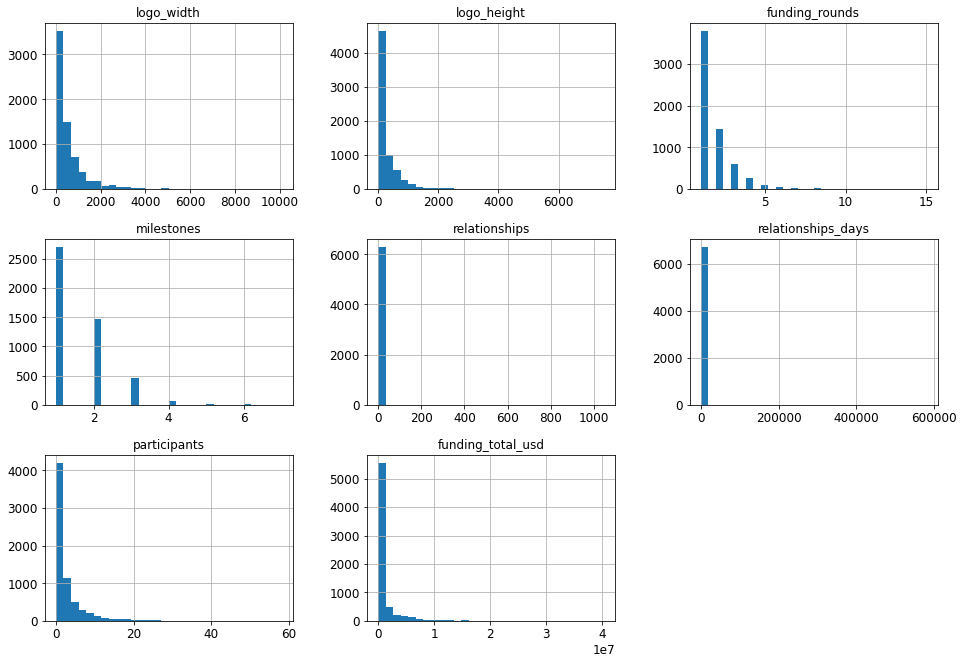

In [70]:
funding.hist(bins=30, figsize=(16,11))
plt.show()

__Note__: Our attributes have very different scales, so we need to perform _**feature scaling**_.

### Creating a Test Set

We will use the random number's generator seed to make sure that the same test set will be produced every time we run our program (this way our algorithm will not get to see the whole dataset since the same shuffled indices will be produced every time).

__Note__: `funding` will be our __training set__ from now on.

In [71]:
np.random.seed(42)

# splitting the dataset (using random sampling)
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(funding, test_size=0.2, random_state=42)

print("Training set size: ", len(train_set))
print("Test set size: ", len(test_set),"\n")

print("Top rows from the test set")
test_set.head()

Training set size:  5396
Test set size:  1350 

Top rows from the test set


,category_code,status,logo_width,logo_height,funding_rounds,milestones,relationships,persons_names,all_affiliations,persons_birthplaces,persons_titles,relationships_days,full_description,place,participants,funding_total_usd
name,,,,,,,,,,,,,,,,
Lonely Sock,games_video,operating,600.0,450.0,1.0,NaN,1.0,JurajChrappa,Unaffiliated,,Founder&CEO,0.0,"Mobile social games developer games, mobile, s...",Prague Prague CZE,0,500000
Efficiency Exchange,analytics,operating,200.0,94.0,1.0,NaN,4.0,"NeilKataria,TarynSullivan,SamuelZhou,LeeTrout","newBrandAnalytics,Unaffiliated,Unaffiliated,Un...",,"Investor,CEO,R&D,Developer",0.0,Global supply chain analytics energy-managemen...,Virginia - Other VA USA,3,600000
Gingr,mobile,operating,819.0,331.0,1.0,NaN,2.0,"HimanshuBamoria,SagarChandna","Unaffiliated,Unaffiliated",,"founder,founder",0.0,"Whatsapp for local businesses local-space, mob...",Gurgaon Gurgaon IND,0,28000
KlickEx,finance,operating,1280.0,1024.0,3.0,2.0,10.0,"PhilNorman,PhilNorman,RobertBell,RossPeat,Ross...","Unaffiliated,Unaffiliated,KlickEx,Unaffiliated...",USA,"Board,Director,CompanyManager,CEO,HeadofRetail...",4371.0,"money-transfer, inter-bank-payments, payments...",Athens Athens GRC,1,185000
PropelAd.com,advertising,operating,177.0,54.0,1.0,2.0,4.0,"CharlieArdagh,GaryRafferty,TadhgO'Toole,JohnLa...","Unaffiliated,Unaffiliated,BloomEquity,PropelAd...","Dublin,Ireland-Dublin","CEO/Founder,CTO,Director/Investor,VPMarketing",0.0,"Facebook Ads optimization service. ireland, f...",Dublin Dublin IRL,2,150000


__Note__: We generated our test set using _**random sampling**_. Normally we would discuss with the **_relevant stakeholders_** to understand whether a feature is really important for predicting company success (in our case for predicting the total Angel and Series A funding in usd specifically) and we would then perform _**stratified sampling**_ based on that feature to ensure that the test set is representative of the various categories of the feature in the entire dataset. That way we would reduce the potential __sampling bias__ introduced via random sampling (this method could prove problematic especially if our dataset is not large enough relative to the number of features).

## Visualizing the data

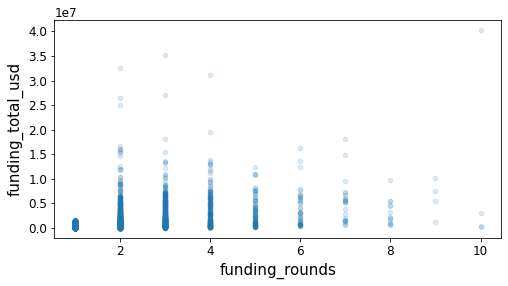

In [72]:
# 'funding' will be our training set from this point on
funding = train_set.copy()

# plotting the total funding (aggregated Angel and Series A funding) against the funding rounds (for up to 10 rounds)
funding.loc[funding['funding_rounds']<=10].plot(kind='scatter',x='funding_rounds',y='funding_total_usd',alpha=0.15,figsize=(8,4))
plt.show()

__Comment__: The number of funding rounds for similar aggregated Angel and Series A total fundings varies considerably. A reason for that is that our data is not comprehensive (many rounds have not been disclosed).

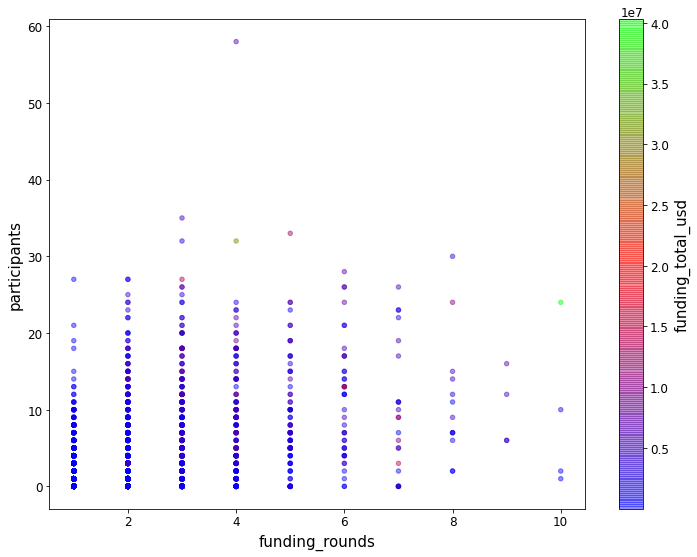

In [73]:
# plotting the number of total participants against the funding rounds number (for up to 10 rounds) and taking a 
# look at the related total angel and series A fundings (using the colorbar)
funding.loc[funding['funding_rounds']<=10].plot(kind='scatter', x='funding_rounds', y='participants', alpha=0.45, 
            figsize=(12,9), c='funding_total_usd',cmap=plt.get_cmap("brg"), colorbar=True, sharex=False)
plt.show()

__Note__: From the __total fundings scatteplot__ it seems that the total Angel and Series A funding of a company is related to the total number of participants of the company to an extent, a definite trend cannot be spotted though, as the incomplete input data has taken its toll on this chart as well. In general though it seems that the more participants a company has the better.

In [74]:
print(f"Statistics of total fundings (aggregated angel and series A fundings)\n")
print(funding['funding_total_usd'].describe(), "\n")

# the company with the highest total funding
print(f"Some information about the company with the highest total (aggregated angel and series A) funding\n")
print(funding[['funding_rounds','funding_total_usd','relationships','participants']].loc[funding['funding_total_usd'] == funding['funding_total_usd'].max()])

Statistics of total fundings (aggregated angel and series A fundings)

count    5.396000e+03
mean     1.084400e+06
std      2.219738e+06
min      1.000000e+03
25%      1.000000e+05
50%      4.250000e+05
75%      1.000000e+06
max      4.028600e+07
Name: funding_total_usd, dtype: float64 

Some information about the company with the highest total (aggregated angel and series A) funding

            funding_rounds  funding_total_usd  relationships  participants
name                                                                      
Livescribe            10.0           40286000           11.0            24


### Looking for correlations

We will compute the **_standard correlation coefficient_** (__Pearson's r__) for every pair of numerical attributes and then examine to which extent each attribute correlates with the `total_funding_usd` (the aggregated Angel and Series A funding).

In [75]:
corr_matrix = funding.corr()
corr_matrix

,logo_width,logo_height,funding_rounds,milestones,relationships,relationships_days,participants,funding_total_usd
logo_width,1.000000,0.764795,0.003987,-0.033772,0.011176,0.005837,0.006034,0.000557
logo_height,0.764795,1.000000,-0.021485,-0.077972,-0.005192,-0.003201,-0.024091,-0.038115
funding_rounds,0.003987,-0.021485,1.000000,0.334789,0.133747,0.030955,0.501707,0.464419
milestones,-0.033772,-0.077972,0.334789,1.000000,0.159305,0.084989,0.377495,0.315842
relationships,0.011176,-0.005192,0.133747,0.159305,1.000000,0.966704,0.136954,0.255189
relationships_days,0.005837,-0.003201,0.030955,0.084989,0.966704,1.000000,0.037716,0.181807
participants,0.006034,-0.024091,0.501707,0.377495,0.136954,0.037716,1.000000,0.459204
funding_total_usd,0.000557,-0.038115,0.464419,0.315842,0.255189,0.181807,0.459204,1.000000


In [76]:
corr_matrix['funding_total_usd'].sort_values(ascending=False)

funding_total_usd     1.000000
funding_rounds        0.464419
participants          0.459204
milestones            0.315842
relationships         0.255189
relationships_days    0.181807
logo_width            0.000557
logo_height          -0.038115
Name: funding_total_usd, dtype: float64

__Note__: As we can see the strongest _positive correlation_ for the given dataset exists between the `funding_total_usd` and the `funding_rounds` and `participants` features, meaning e.g. that the __total Angel and Series A funding__ tends to go up when the __number of participants__  increases. As regards the `logo_width` and `logo_width` features, their correlation coefficients are close to zero, so there is _no linear correlation_ between them and the _total funding_. That was more or less expected and in case we - for some reason - felt like exploring further the distant possibility of the logo dimensions of a company having any actual impact on funding, we could construct the following scatterplot.

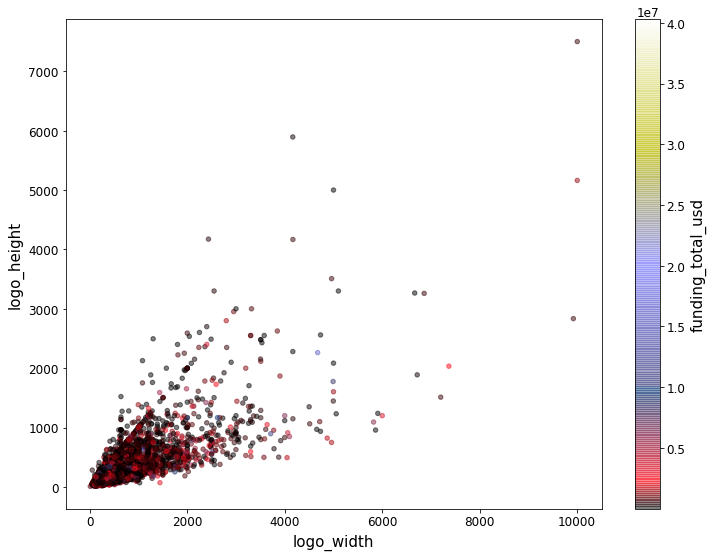

In [77]:
funding.plot(kind='scatter', x='logo_width', y='logo_height', alpha=0.5, figsize=(12,9),
             c='funding_total_usd',cmap=plt.get_cmap("gist_stern"), colorbar=True, sharex=False)
plt.show()

We cannot identify a pattern here. We can now remove the logo dimensions features (from every dataset).

In [78]:
funding = funding.drop(['logo_width', 'logo_height'],axis=1)
# removing the features from the training set we created earlier
train_set = train_set.drop(['logo_width', 'logo_height'],axis=1)
# removing the features from the test set we created earlier
test_set = test_set.drop(['logo_width', 'logo_height'],axis=1)

Let's now plot every numerical feature against every other numerical feature to **check for correlations**. We will focus on the most promising features, meaning features that seem most correlated with the total funding.

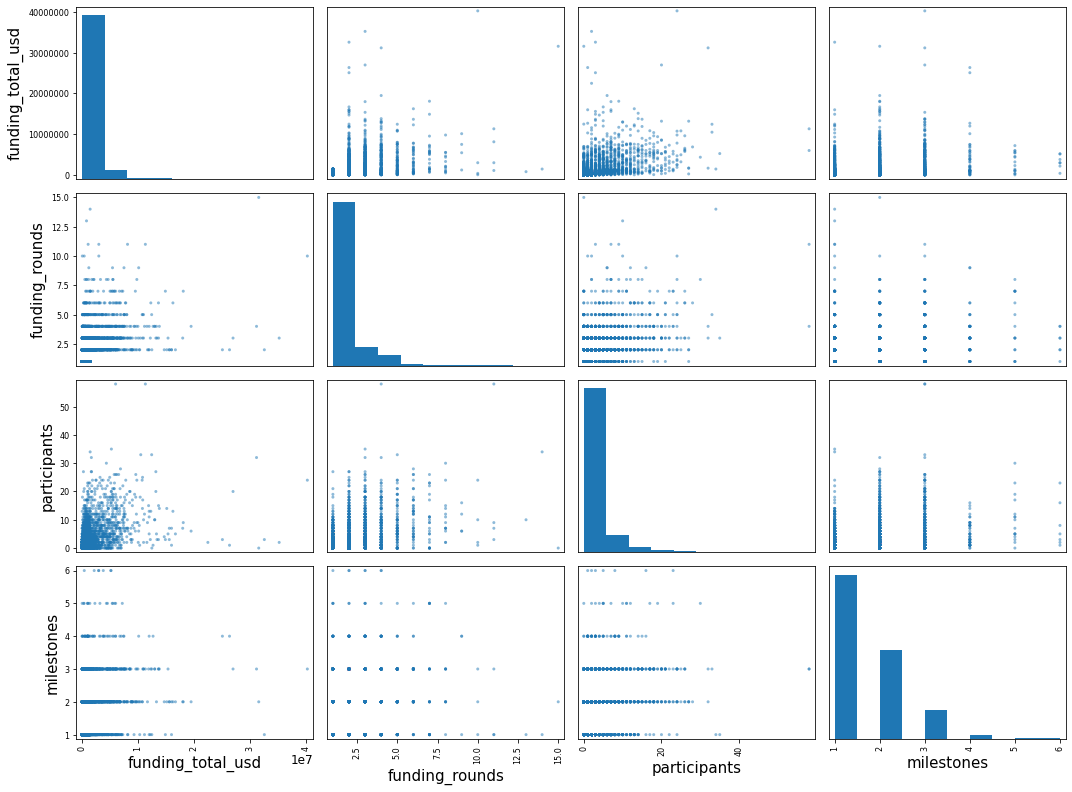

In [79]:
from pandas.plotting import scatter_matrix

features = ['funding_total_usd','funding_rounds','participants','milestones']
scatter_matrix(funding[features], figsize=(15,11))
plt.tight_layout()
plt.show()

One of the most promising features to predict a company's total Angel and Series A funding is the total number of its participants, so we will examine the correlation scatterplot of these features on its own.

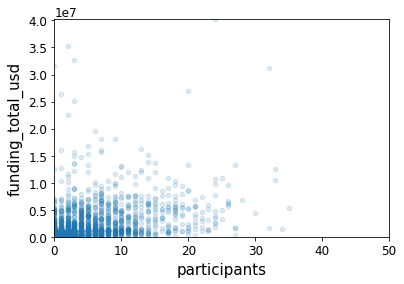

In [80]:
funding.plot(kind='scatter',x='participants',y='funding_total_usd',alpha=0.15)
plt.axis([0, 50, 0, 4.02e+7])
plt.show()

__Note__: As we can see from this plot there is a relatively strong correlation (there is an upward trend, especially for a number of participants less than 15, as the aggregated Angel and Series A fundings seem to be getting bigger in general and the data points are not very dispersed).

## Preparing the data for Machine Learning algorithms

In [81]:
# separating predictors and labels
funding = train_set.drop("funding_total_usd",axis=1)
funding_labels = train_set["funding_total_usd"].copy()

### Data Cleaning

As we mentioned earlier 3 of our features still have missing values. We will deal with this by setting the missing values to _zero_ for the `milestones` attribute (this could have some implications, but given the incomplete data we have we'll proceed) and to the _median_ for the `funding_rounds` and `relationships` attributes (the median needs to be computed on the training set).

In [82]:
# top counts of values for 'milestones' (including NaNs)
print(f"Top 3 counts of values for 'milestones' (including NaNs)\n")
print(funding["milestones"].value_counts(dropna=False).head(3),"\n")

# setting NaNs to zero
print("Setting nulls to zero")
funding["milestones"] = funding["milestones"].fillna(0)

Top 3 counts of values for 'milestones' (including NaNs)

1.0    2163
NaN    1610
2.0    1176
Name: milestones, dtype: int64 

Setting nulls to zero


We will deal with the remaining missing values using sklearn's `SimpleImputer`. We first need to remove all the text attributes and then we will fit the `imputer` instance to the training data (since the median can only be computed on numerical features).

In [83]:
# getting the numerical features
funding_num = funding.select_dtypes(include=['number'])

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# fitting the imputer to the training data only
imputer.fit(funding_num)

SimpleImputer(strategy='median')

In [84]:
# checking the calculated median values
print(imputer.statistics_)

# calculating the medians "manually" for comparison reasons
print(funding_num.median().values)

[1. 1. 3. 0. 1.]
[1. 1. 3. 0. 1.]


Our "trained" imputer will now be utilised to transform the training set (missing values will be replaced with the learned medians).

In [85]:
X = imputer.transform(funding_num)

funding_num_tr = pd.DataFrame(X, columns=funding_num.columns, index=funding_num.index)
funding_num_tr.head()

,funding_rounds,milestones,relationships,relationships_days,participants
name,,,,,
SteadyFare,1.0,0.0,3.0,0.0,0.0
Bondsy,2.0,2.0,8.0,0.0,7.0
Local Magnet,1.0,0.0,1.0,0.0,0.0
MondeCafes,2.0,1.0,2.0,0.0,0.0
Ark,3.0,2.0,6.0,153.0,20.0


### Feature Scaling

Our _numerical features_ have different scales, so we need to apply feature scaling. More specifically we will apply __standardization__ using sklearn's _StandardScaler_ transformer.

In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fitting the scaler to the training data only
scaler.fit(funding_num_tr)
X1 = scaler.transform(funding_num_tr)

print("Relative data scaling (in order to achieve zero mean and unit variance) per feature:","\n")
print(scaler.scale_, "\n")
print("Mean per feature (in the training set):","\n")
print(scaler.mean_)

# creating a DataFrame to take a look
funding_num_tr = pd.DataFrame(X1, columns=funding_num_tr.columns, index=funding_num_tr.index)
funding_num_tr.head()

Relative data scaling (in order to achieve zero mean and unit variance) per feature: 

[1.19853267e+00 9.72134650e-01 1.48387286e+01 8.03782128e+03
 4.22033513e+00] 

Mean per feature (in the training set): 

[  1.67420311   1.10415122   4.25982209 429.63880652   2.44977761]


,funding_rounds,milestones,relationships,relationships_days,participants
name,,,,,
SteadyFare,-0.562524,-1.135801,-0.084901,-0.053452,-0.580470
Bondsy,0.271830,0.921527,0.252055,-0.053452,1.078166
Local Magnet,-0.562524,-1.135801,-0.219683,-0.053452,-0.580470
MondeCafes,0.271830,-0.107137,-0.152292,-0.053452,-0.580470
Ark,1.106183,0.921527,0.117273,-0.034417,4.158490


In [87]:
# converting the funding_num_tr DataFrame to a sparse matrix
from scipy.sparse import csr_matrix
funding_num_tr = csr_matrix(funding_num_tr.values)
funding_num_tr

<5396x5 sparse matrix of type '<class 'numpy.float64'>'
	with 26980 stored elements in Compressed Sparse Row format>

Our numerical features are now preprocessed and ready (in the `funding_num_tr` sparse matrix).

### Handling text and categorical features

We have various text attributes in our dataset, and some of those are categorical.

**<ins>_Categorical attributes_ preprocessing</ins>**

In [88]:
categorical_cols = ['category_code', 'status']

# getting the categorical features
funding_cat = funding[categorical_cols]

print(f"Most common values for 'category_code'\n\n{funding['category_code'].value_counts().head()}\n")
print(f"Value counts for 'status'\n\n{funding['status'].value_counts()}\n")

print("Some values of the categorical features")
funding_cat.head(10)

Most common values for 'category_code'

web            829
software       699
mobile         520
ecommerce      407
games_video    302
Name: category_code, dtype: int64

Value counts for 'status'

operating    4649
closed        440
acquired      293
ipo            14
Name: status, dtype: int64

Some values of the categorical features


,category_code,status
name,,
SteadyFare,travel,closed
Bondsy,web,operating
Local Magnet,local,operating
MondeCafes,hospitality,operating
Ark,search,operating
MindEdge,other,operating
PLYmedia,advertising,operating
SwapBeats,software,operating
REMOTV,mobile,closed


In the case of _categorical features_ we are not dealing with arbitrary text, we instead have a limited number of possible values and each of them represents a category. Most Machine Learning algorithms prefer to work with numbers, so we will convert these categories from text to numbers. Our categories are not ordered, so we will apply **_one-hot encoding_**, meaning we will create one binary attribute per category: one attribute will be equal to 1 (hot), while the others will be 0 (cold). We will use sklearn's `OneHotEncoder` class to convert categorical values into one-hot vectors.

In [89]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
funding_cat_1hot = cat_encoder.fit_transform(funding_cat)
funding_cat_1hot

<5396x46 sparse matrix of type '<class 'numpy.float64'>'
	with 10792 stored elements in Compressed Sparse Row format>

In [90]:
# viewing the various categories of categorical features
cat_encoder.categories_

[array(['advertising', 'analytics', 'automotive', 'biotech', 'cleantech',
        'consulting', 'design', 'ecommerce', 'education', 'enterprise',
        'fashion', 'finance', 'games_video', 'government', 'hardware',
        'health', 'hospitality', 'legal', 'local', 'manufacturing',
        'medical', 'messaging', 'mobile', 'music', 'nanotech',
        'network_hosting', 'news', 'nonprofit', 'other', 'pets',
        'photo_video', 'public_relations', 'real_estate', 'search',
        'security', 'semiconductor', 'social', 'software', 'sports',
        'transportation', 'travel', 'web'], dtype=object),
 array(['acquired', 'closed', 'ipo', 'operating'], dtype=object)]

**<ins>Remaining _text (non-categorical) attributes_ preprocessing</ins>**

We will implement the __Bag-of-Words Model__, and more specifically the **TF-IDF** approach for the remaining text attributes.

In [91]:
# getting all the 'object' features
object_cols = funding.select_dtypes(include=['object']).columns

# getting the remaining (non-categorical) text attributes
text_cols = [col for col in object_cols if col not in categorical_cols]
text_cols

['persons_names',
 'all_affiliations',
 'persons_birthplaces',
 'persons_titles',
 'full_description',
 'place']

In [92]:
# IMPLEMENTING THE TF-IDF APPROACH
encoded_vectors = []

from sklearn.feature_extraction.text import TfidfVectorizer

for col in text_cols:
    text = funding[col].tolist()
    vectorizer = TfidfVectorizer()
    # tokenizing and building the vocabulary
    vectorizer.fit(text)
    # encoding the text
    vector = vectorizer.transform(text)
    encoded_vectors.append(vector)
    
# concatenating the sparse matrices we got after applying tf-idf
from scipy.sparse import hstack
funding_text_tfidf = hstack((encoded_vectors))

# concatenating all sparse matrices (for numerical, categorical, and other text fearures)
funding_prep = hstack((funding_num_tr, funding_cat_1hot, funding_text_tfidf))
funding_prep

<5396x41161 sparse matrix of type '<class 'numpy.float64'>'
	with 165820 stored elements in COOrdinate format>

### Transformation pipelines

At this point we will use sklearn's `Pipeline` class to implement all the previous transformations more easily, quickly and in a centralised way. We will first build a **pipeline for preprocessing our numerical features**.

In [93]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("standard_scaler", StandardScaler())
])

funding_tr_num = num_pipeline.fit_transform(funding_num)

funding_tr_num

array([[-0.56252377, -1.13580071, -0.08490095, -0.05345215, -0.58046992],
       [ 0.27182979,  0.92152746,  0.25205515, -0.05345215,  1.07816613],
       [-0.56252377, -1.13580071, -0.21968338, -0.05345215, -0.58046992],
       ...,
       [-0.56252377, -0.10713662,  0.11727271, -0.05345215,  0.1303741 ],
       [-0.56252377, -1.13580071, -0.08490095, -0.05345215, -0.58046992],
       [ 1.94053692,  0.92152746,  1.53248829,  0.25496476, -0.34352192]])

We can actually use a single transformer able to handle all columns, numerical and text ones (categorical or not), in order to apply the appropriate transformations to each column without having to handle numerical and text features separately.

In [94]:
from sklearn.compose import ColumnTransformer

num_features = list(funding_num)
cat_features = categorical_cols
text_rest_features = text_cols

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", OneHotEncoder(), cat_features),
    ("tfidf1", TfidfVectorizer(), text_rest_features[0]),
    ("tfidf2", TfidfVectorizer(), text_rest_features[1]),
    ("tfidf3", TfidfVectorizer(), text_rest_features[2]),
    ("tfidf4", TfidfVectorizer(), text_rest_features[3]),
    ("tfidf5", TfidfVectorizer(), text_rest_features[4]),
    ("tfidf6", TfidfVectorizer(), text_rest_features[5])
])

funding_prepared = full_pipeline.fit_transform(funding)
funding_prepared

<5396x41161 sparse matrix of type '<class 'numpy.float64'>'
	with 165820 stored elements in Compressed Sparse Row format>

## Selecting and training a model

We are now ready to select and train a Machine Learning model.

### Training and evaluating on the training set

We will first train a __Linear Regression__ model and try it out on some instances from the training set.

In [95]:
from sklearn.linear_model import LinearRegression

# training the model
lin_reg = LinearRegression()
lin_reg.fit(funding_prepared, funding_labels)

some_data = funding.iloc[:5]
some_labels = funding_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print(f"Predictions: {np.round_(lin_reg.predict(some_data_prepared))}")
print(f"Labels: {list(some_labels)}") # actual values

Predictions: [  24993.  754469.   25000.  135673. 5249996.]
Labels: [25000, 754466, 25000, 135668, 5250000]


We can see that most of our predictions are way too accurate.

Now let's measure this regression model's RMSE on the entire training set.

In [96]:
from sklearn.metrics import mean_squared_error

funding_predictions_lr = lin_reg.predict(funding_prepared)

# using the root mean squared error as the performance measure
lin_reg_mse = mean_squared_error(funding_labels, funding_predictions_lr)
lin_reg_rmse = np.sqrt(lin_reg_mse)

# using the mean absolute error as the performance measure
from sklearn.metrics import mean_absolute_error

lin_reg_mae = mean_absolute_error(funding_labels, funding_predictions_lr)
print(f"RMSE: {lin_reg_rmse}\nMAE:{lin_reg_mae}")

RMSE: 11.58207771230716
MAE:6.994217336382006


__Note__: The _Mean Absolute Error_ is probably a better performance measure choice for our case as it is less sensitive to outliers (and we do have outliers in our data).

In [97]:
print(f"Our target feature (Aggregated Angel and Series A fundings): {funding_labels.name}")
# descriptive statistics of our target feature
funding_labels.describe()

Our target feature (Aggregated Angel and Series A fundings): funding_total_usd


count    5.396000e+03
mean     1.084400e+06
std      2.219738e+06
min      1.000000e+03
25%      1.000000e+05
50%      4.250000e+05
75%      1.000000e+06
max      4.028600e+07
Name: funding_total_usd, dtype: float64

__Note__: As we can see the median of the aggregated angel and series A fundings (the 2nd quartile) \\$425,000, so a typical prediction error of almost \\$11,6 (RMSE) or \\$7 when using the MAE denotes *overfitting of the training data*.

We will now try a __Decision Tree Regression__ model.

In [98]:
from sklearn.tree import DecisionTreeRegressor

# training the model
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(funding_prepared, funding_labels)

# evaluating on the training set
funding_predictions_tr = tree_reg.predict(funding_prepared)

tree_reg_rmse = mean_squared_error(funding_labels, funding_predictions_tr, squared=False)
print("RMSE: ", tree_reg_rmse, "\n")

tree_reg_mae = mean_absolute_error(funding_labels, funding_predictions_tr)
print("MAE", tree_reg_mae)

RMSE:  0.0 

MAE 0.0


__Note__: The DecisionTreeRegressor is a model more powerful than linear regression capable of identifying complex nonlinear relationships in a dataset. When using this model we get a _mean squared error_ and a _mean absolute error_ of 0 (meaning there is no error at all), so this model seems to be overfitting the training dataset to a great extent. We will confirm that this is the case using cross-validation by utilising a part of the training set for training and a part for model validation (we should not touch the test set for for evaluation purposes).

### Cross-validation

We will utilise sklearn's _K-fold cross-validation_ feature to evaluate the **Decision Tree Regression model**.

In [99]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, funding_prepared, funding_labels,
                                 scoring="neg_mean_absolute_error", cv=5)
tree_scores_mae = -scores

**Note**: Sklearn's cross-validation features don't expect a cost function, but a utility function, so the scoring function provides the opposite of the MAE; this explains the negative sign in the last line of code in the previous cell.

In [100]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Standard Deviation: {scores.std()}")

In [101]:
display_scores(tree_scores_mae)

Scores: [ 933359.81203704 1032784.15384615 1021578.59684893 1064932.
  891127.50046339]
Mean: 988756.4126391032
Standard Deviation: 65450.20356386113


The scores mean provides an estimate of model performance and the standard deviation of the scores is a measure of how precise this estimate is. So, after all, the Decision Tree actually seems to be performing pretty bad (with an error of almost \\$990,000) and is overfitting the training set. For comparison reasons we will also calculate the same scores for the Linear Regression model.

In [102]:
# cross-validation for the linear regression model
scores = cross_val_score(lin_reg, funding_prepared, funding_labels,
                        scoring='neg_mean_absolute_error', cv=5)
lin_scores_mae = -scores

display_scores(lin_scores_mae)

Scores: [1006668.49619639 1111467.64136087 1021466.70827843 1080413.4037909
  971409.29568027]
Mean: 1038285.1090613721
Standard Deviation: 50764.7899235624


The linear regression model's error is even higher, so it performs worse than the Decision Tree model. Our data seems fairly ripe for overfitting so we will add __L1 and L2 regularisation__ to the linear regression model.

In [103]:
# adding L1 regularisation
from sklearn.linear_model import Lasso
from statistics import mean

alphas_scores_lasso = []

for alpha_val in np.arange(0.4,2.1,0.4):
    lasso_reg = Lasso(alpha=alpha_val, tol=0.09, random_state=42)
    lasso_reg.fit(funding_prepared, funding_labels)
    scores = cross_val_score(lasso_reg, funding_prepared, funding_labels, 
                                scoring='neg_mean_absolute_error', cv=5)
    scores = -scores
    avg_scores_lasso_mae = mean(scores)*100
    alphas_scores_lasso.append([avg_scores_lasso_mae,alpha_val, scores])

# choosing the optimal alpha
min_scores = alphas_scores_lasso[0][0]
best_cv_scores = alphas_scores_lasso[0][2]
for i in range(1,len(alphas_scores_lasso)):
    if alphas_scores_lasso[i][0] < min_scores:
        best_alpha_lasso = alphas_scores_lasso[i][1]
        best_cv_scores = alphas_scores_lasso[i][2]

print("Best alpha: ", best_alpha_lasso)

# training the final lasso regression model
lasso_reg = Lasso(alpha=best_alpha_lasso, tol=0.09, random_state=42)
lasso_reg.fit(funding_prepared, funding_labels)

funding_predictions_lasso = lasso_reg.predict(funding_prepared)

# evaluating on the training set
lasso_reg_mae = mean_absolute_error(funding_labels, funding_predictions_lasso)
print("MAE", lasso_reg_mae)

# cross-validation
display_scores(best_cv_scores)

Best alpha:  2.0
MAE 10742.010682137972
Scores: [ 918313.9333099  1082477.39923379  999896.23789654 1010700.95709098
  884883.30445494]
Mean: 979254.3663972296
Standard Deviation: 70270.33961810262


In [104]:
# adding L2 regularisation
from sklearn.linear_model import Ridge

alphas_scores_ridge = []

for alpha_val in np.arange(0.4,2.1,0.4):
    ridge_reg = Ridge(alpha=alpha_val, random_state=42)
    ridge_reg.fit(funding_prepared, funding_labels)
    scores = cross_val_score(ridge_reg, funding_prepared, funding_labels, 
                                scoring='neg_mean_absolute_error', cv=5)
    scores = -scores
    avg_scores_ridge_mae = mean(scores)*100
    alphas_scores_ridge.append([avg_scores_ridge_mae,alpha_val, scores])

# choosing the optimal alpha
min_scores = alphas_scores_ridge[0][0]
best_cv_scores = alphas_scores_ridge[0][2]
for i in range(1,len(alphas_scores_ridge)):
    if alphas_scores_ridge[i][0] < min_scores:
        best_alpha_ridge = alphas_scores_ridge[i][1]
        best_cv_scores = alphas_scores_ridge[i][2]

print("Best alpha: ", best_alpha_ridge)

# training the final ridge regression model
ridge_reg = Ridge(alpha=best_alpha_ridge, random_state=42)
ridge_reg.fit(funding_prepared, funding_labels)

funding_predictions_ridge = ridge_reg.predict(funding_prepared)

# evaluating on the training set
ridge_reg_mae = mean_absolute_error(funding_labels, funding_predictions_ridge)
print("MAE", ridge_reg_mae)

# cross-validation
display_scores(best_cv_scores)

Best alpha:  2.0
MAE 391560.1421385844
Scores: [ 927731.15119339 1031731.21594709  962559.48961421 1015686.43040347
  873542.36576498]
Mean: 962250.1305846276
Standard Deviation: 57868.44138560362


The L1 and L2 regularisation techniques improved the MAE a bit (Ridge Regression provided a slightly better result).

We will now try a __Random Forest Regression__ model.

In [105]:
from sklearn.ensemble import RandomForestRegressor

# training the model
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(funding_prepared, funding_labels)

# evaluating on the training set
funding_predictions_rf = forest_reg.predict(funding_prepared)
forest_reg_mae = mean_absolute_error(funding_labels, funding_predictions_rf)
print(f"MAE (training set): {forest_reg_mae}\n")

# cross-validation
scores = cross_val_score(forest_reg, funding_prepared, funding_labels,
                        scoring='neg_mean_absolute_error', cv=5)
forest_scores_mae = -scores

display_scores(forest_scores_mae)

MAE (training set): 290256.2873498888

Scores: [736589.2485463  838385.65589435 811928.20569972 833142.94601483
 668728.01916589]
Mean: 777754.8150642175
Standard Deviation: 65564.0307304139


In [106]:
# descriptive statistics for the Random Forest's cross-validation score
pd.Series(forest_scores_mae).describe()

count         5.000000
mean     777754.815064
std       73302.814796
min      668728.019166
25%      736589.248546
50%      811928.205700
75%      833142.946015
max      838385.655894
dtype: float64

__Note__: The Random Forest seems like the best solution so far. However, its score on the training set (approx. \\$290,256) is lower than on the validation sets (approx. \\$777,755), so this model is still overfitting the training set.

We will try out a __Support Vector Machine__ model as well.

In [107]:
from sklearn.svm import SVR

# training the model
svm_reg = SVR(kernel='linear')
svm_reg.fit(funding_prepared, funding_labels)

# evaluating on the training set
funding_predictions_svm = svm_reg.predict(funding_prepared)
svm_reg_mae = mean_absolute_error(funding_labels, funding_predictions_svm)
print("MAE (training set)", svm_reg_mae, "\n")

# cross-validation
scores = cross_val_score(svm_reg, funding_prepared, funding_labels,
                        scoring='neg_mean_absolute_error', cv=5)
svm_reg_scores_mae = -scores

display_scores(svm_reg_scores_mae)

MAE (training set) 936969.7313185635 

Scores: [ 889485.22043765 1027670.49761732  938694.76598765  964022.55629045
  867167.07765158]
Mean: 937408.0235969285
Standard Deviation: 56723.34408812242


The SVM model is not a great performer as well, even when evaluating the model on the training set.

### Fine-tuning our models

We will search for the best combination of hyperparameters for the Random Forest Regression model with Scikit-Learn's `GridSearchCV`. We will try 21 combinations of RandomForestRegressor hyperparameter values with five-fold cross-validation, and that means we will have 105 rounds of training.

In [108]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 1st stage: evaluation of 12 combinations of hyperparameter values
    {"n_estimators": [10,30,100], "max_features": [2,4,6,8]},
    # 2nd stage: evaluation 9 combinations of hyperparameters, with the 'bootstrap' hyperparameter set to False
    {"bootstrap": [False], "n_estimators": [10,30,100], "max_features": [2,3,4]}
]

forest_reg_cv = RandomForestRegressor(random_state=42)

# training
grid_search = GridSearchCV(forest_reg_cv, param_grid, scoring="neg_mean_absolute_error",
                          cv=5, return_train_score=True)
grid_search.fit(funding_prepared, funding_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [10, 30, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [10, 30, 100]}],
             return_train_score=True, scoring='neg_mean_absolute_error')

In [109]:
print("Best combination of parameters found: ", grid_search.best_params_, "\n")
print("Best estimator found: ", grid_search.best_estimator_)

Best combination of parameters found:  {'bootstrap': False, 'max_features': 4, 'n_estimators': 100} 

Best estimator found:  RandomForestRegressor(bootstrap=False, max_features=4, random_state=42)


Let's now check the __evaluation scores__ (scores of all hyperparameter combinations tested during the grid search).

In [110]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

976395.213785175 {'max_features': 2, 'n_estimators': 10}
921423.0066388918 {'max_features': 2, 'n_estimators': 30}
901940.8471499175 {'max_features': 2, 'n_estimators': 100}
993775.8518684311 {'max_features': 4, 'n_estimators': 10}
928018.8961299444 {'max_features': 4, 'n_estimators': 30}
896468.0387418198 {'max_features': 4, 'n_estimators': 100}
973863.3678425669 {'max_features': 6, 'n_estimators': 10}
925047.2308345691 {'max_features': 6, 'n_estimators': 30}
902106.6058927557 {'max_features': 6, 'n_estimators': 100}
965571.534078811 {'max_features': 8, 'n_estimators': 10}
916746.1359100733 {'max_features': 8, 'n_estimators': 30}
896942.5348268116 {'max_features': 8, 'n_estimators': 100}
962405.7260173515 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
921783.0606236283 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
905750.1726371795 {'bootstrap': False, 'max_features': 2, 'n_estimators': 100}
948097.6168731678 {'bootstrap': False, 'max_features': 3, 'n_estima

__Note__: The best solution is obtained by setting the `max_features` and `n_estimators` hyperparameters to 4 and 100 respectively with the `bootstrap` hyperparameter set to False. The resulting MAE score when using this combination is approx. \\$889,361 and it is not as good as the score we achieved using the Random Forest with 100 estimators and default hyperparameter values.

### Analysing the best models

We will now inspect our best models to gain deeper insight into our project. For instance, the `RandomForestRegressor` can provide each feature's relative importance for making accurate predictions. We can also view the fitted transformers and the values of categorical attributes.

In [111]:
# selecting the best model we built
feature_importances = forest_reg.feature_importances_
print("Feature importances: ", feature_importances, "\n")

# fitted transformers
print(f"Fitted transformers\n")
print(full_pipeline.transformers_, "\n")

# values of categorical features
print(f"Values of categorical features\n")
print(full_pipeline.named_transformers_["cat"].categories_, "\n")

# displaying the importance scores next to their corresponding feature names
print(f"Importance scores for features and the specific values of the 'status' feature")
cat_1hot_some = list(full_pipeline.named_transformers_["cat"].categories_[1])
attributes = num_features + cat_features + text_rest_features + cat_1hot_some
sorted(zip(feature_importances, attributes), reverse=True)

Feature importances:  [1.11871194e-01 3.79883667e-03 4.43477316e-02 ... 3.87844458e-08
 8.95725123e-08 1.79426170e-07] 

Fitted transformers

[('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standard_scaler', StandardScaler())]), ['funding_rounds', 'milestones', 'relationships', 'relationships_days', 'participants']), ('cat', OneHotEncoder(), ['category_code', 'status']), ('tfidf1', TfidfVectorizer(), 'persons_names'), ('tfidf2', TfidfVectorizer(), 'all_affiliations'), ('tfidf3', TfidfVectorizer(), 'persons_birthplaces'), ('tfidf4', TfidfVectorizer(), 'persons_titles'), ('tfidf5', TfidfVectorizer(), 'full_description'), ('tfidf6', TfidfVectorizer(), 'place')] 

Values of categorical features

[array(['advertising', 'analytics', 'automotive', 'biotech', 'cleantech',
       'consulting', 'design', 'ecommerce', 'education', 'enterprise',
       'fashion', 'finance', 'games_video', 'government', 'hardware',
       'health', 'hospitality', 'legal', '

[(0.14021887574857722, 'participants'),
 (0.1118711940543896, 'funding_rounds'),
 (0.044347731646971235, 'relationships'),
 (0.008258778964532672, 'relationships_days'),
 (0.0037988366682991863, 'milestones'),
 (0.0009221009772429535, 'operating'),
 (0.0004885882777409507, 'place'),
 (0.0003337735631594667, 'all_affiliations'),
 (0.00031835623158927114, 'closed'),
 (0.0002625339914266908, 'status'),
 (0.0002559579029292212, 'category_code'),
 (0.0001912569980381114, 'persons_birthplaces'),
 (0.0001862537006563335, 'ipo'),
 (0.00018414398273939212, 'persons_names'),
 (7.143345648007498e-05, 'persons_titles'),
 (6.878065970474118e-05, 'acquired'),
 (1.2999882015477101e-05, 'full_description')]

### Evaluating on the test set

We will now evaluate our best model (not the one we got from grid search) on the test set.

In [112]:
final_model = forest_reg

# getting predictors and labels from our test set
X_test = test_set.drop('funding_total_usd',axis=1)
y_test = test_set['funding_total_usd'].copy()

# transforming the data (with transform(), not fit_transform() as we don't want to fit the test set)
X_test_prepared = full_pipeline.transform(X_test)

# evaluating on the test set
final_predictions = final_model.predict(X_test_prepared)
final_model_mae = mean_absolute_error(y_test, final_predictions)
print(f"Test MAE (Random Forest): {final_model_mae}")

Test MAE (Random Forest): 830682.7062962963


__Note__: We will now get an idea of how precise the estimate of the generalization error is by calculating the **95% confidence interval for the generalization error** (the test MAE).

In [113]:
from scipy import stats

confidence = 0.95
absolute_errors = np.abs(final_predictions - y_test)
conf_interval_mae = stats.t.interval(confidence, len(absolute_errors) - 1,
                                    loc=absolute_errors.mean(),
                                    scale=stats.sem(absolute_errors))
print("95% confidence interval for the test MAE (Random Forest): ", conf_interval_mae)

95% confidence interval for the test MAE (Random Forest):  (738361.5306784505, 923003.8819141422)


And now let's see how many startups will raise a Series A based on our predictions (using the \\$1.75M threshold based on the 99th percentile of the Angel fundings feature and using the \\$1M threshold based on the 15th percentile of the Series A fundings).

In [114]:
# predictions below/above a Series A threshold of $1.75M
print(f"Series A predictions for a $1.75M threshold ('True' means a Series A was raised)\n")
print((pd.Series(final_predictions) >= 1750000).value_counts(), "\n")

# respective percentages
print(f"Respective percentages\n")
print((pd.Series(final_predictions) >= 1750000).value_counts(normalize=True), "\n")

# predictions below/above a Series A threshold of $1M
print(f"Series A predictions for a $1M threshold ('True' means a Series A was raised)\n")
print((pd.Series(final_predictions) >= 1000000).value_counts(), "\n")

# respective percentages
print(f"Respective percentages\n")
print((pd.Series(final_predictions) >= 1000000).value_counts(normalize=True), "\n")

# our Series A fundings predictions (using the Series A approximate percentage we calculated earlier)
print(f"Actual predicted Series A fundings\n")
pd.Series(final_predictions * seriesa_pct_mean)

Series A predictions for a $1.75M threshold ('True' means a Series A was raised)

False    1161
True      189
dtype: int64 

Respective percentages

False    0.86
True     0.14
dtype: float64 

Series A predictions for a $1M threshold ('True' means a Series A was raised)

False    1013
True      337
dtype: int64 

Respective percentages

False    0.75037
True     0.24963
dtype: float64 

Actual predicted Series A fundings



0       1.248463e+05
1       8.743894e+05
2       1.446050e+05
3       2.342650e+06
4       4.121667e+05
            ...     
1345    5.721943e+05
1346    4.122541e+05
1347    5.486544e+04
1348    1.834694e+06
1349    2.491129e+05
Length: 1350, dtype: float64

<ins>__Final comments__</ins>

Based on our predictions, not many companies will manage to raise a Series A funding (just 14% of the startups). This is not really accurate, as in reality (and according to this crunchbase article: https://news.crunchbase.com/news/what-does-it-take-to-raise-your-next-round-in-2018/#:~:text=Less%20than%20half%20of%20seed,to%20raise%20their%20Series%20A.) that percentage is around 42% (to be fair that information refers to year 2018, but the predictions are still a bit off). If we lower the Series A threshold to \\$1M (to account for many low Series A fundings that we discovered in the data via a quick approximation) that percentage increases to approx. 25\%, which is closer to the real number (a \\$1M lower Series A threshold though is too low even for the 2013 standards for a Series A). These results were more or less expected due to the incomplete input data utilsied for this project and can mainly be attributed to the many undisclosed funding rounds of startups. In the future, and as my ML knowledge is enhanced, I might come back and apply more advanced models as well. The data issue will remain though, but in any case this project was a great learning experience!

**Note**: The approach presented here can be used for predicting whether a company will raise later stage rounds too (Series B etc) with some minor tweaks.